In [20]:
import os
import time

import dill as pickle

import functools
import operator
from datetime import datetime, timedelta
from multiprocessing import Pool
import shutil

import numpy as np
import pandas as pd
pd.options.display.max_rows = 99
pd.options.display.max_columns = 99
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from covid_model_deaths.data import get_input_data, plot_crude_rates, DeathModelData
from covid_model_deaths.social_distancing_cov import SocialDistCov
from covid_model_deaths.drawer import Drawer
from covid_model_deaths.utilities import CompareModelDeaths, MOBILITY_SOURCES, KS, RATE_THRESHOLD, submit_curvefit, get_peak_date
from covid_model_deaths.impute_death_threshold import impute_death_threshold
from covid_model_deaths.moving_average import moving_average_predictions
from covid_model_deaths.compare_moving_average import CompareAveragingModelDeaths

from db_queries import get_location_metadata

import warnings
warnings.simplefilter('ignore')

## Set arguments and run settings ##
RUN_TYPE = 'prod'
DATESTAMP_LABEL = '2020_04_22_Europe'
DATA_VERSION = 'best'
PEAK_FILE = '/ihme/covid-19/deaths/mobility_inputs/2020_04_14/final_peak_locs_04_14.csv'
CASES_DEATHS_FILE = '/ihme/covid-19/deaths/mobility_inputs/2020_04_20/deaths_from_cases.csv'
lsvid = 642

CODE_DIR = os.path.abspath('../src/covid_model_deaths')
OUTPUT_DIR = f'/ihme/covid-19/deaths/{RUN_TYPE}/{DATESTAMP_LABEL}'

# Are we combining with previous predictions?
combine_predictions = True
raw_draw_path = f'{OUTPUT_DIR}/euro_data.csv'
average_draw_path = f'{OUTPUT_DIR}/past_avg_euro_data.csv'
yesterday_draw_path = '/ihme/covid-19/deaths/prod/2020_04_21_Europe/euro_data.csv'
before_yesterday_draw_path = '/ihme/covid-19/deaths/prod/2020_04_20_Europe/euro_data.csv'

# ensemble plot settings
COLOR_DICT = {
    'safegraph':'dodgerblue',
    'google':'forestgreen',
    'descartes':'firebrick'
    #'equal':'gold',
    #'ascmid':'firebrick',
    #'ascmax':'darkviolet'
}
LINE_DICT = {
    #'14':'-',
    '21':'--'
}


In [2]:
# CODE_DIR = os.path.abspath('../src/covid_model_deaths')
# OUTPUT_DIR = f'/ihme/covid-19/deaths/{RUN_TYPE}/{DATESTAMP_LABEL}'

if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)
print(f'Writing to {OUTPUT_DIR}')


Writing to /ihme/covid-19/deaths/prod/2020_04_22_Europe


In [3]:
# come up with more informative names...
input_full_df = get_input_data('full_data', DATA_VERSION)
input_death_df = get_input_data('deaths', DATA_VERSION)
input_age_pop_df = get_input_data('age_pop', DATA_VERSION)
input_age_death_df = get_input_data('age_death', DATA_VERSION)

# manually adjust Iceland spike (0 deaths to 5 deaths to 0 deaths in March...)
input_full_df.loc[(input_full_df['Country/Region'] == 'Iceland') & (input_full_df['Date'] == pd.Timestamp('2020-03-15')), ['Deaths', 'Death rate']] = 0
input_death_df = input_death_df.loc[(input_death_df['Country/Region'] != 'Iceland') | (input_death_df['Date'] != pd.Timestamp('2020-03-15'))]
input_death_df.loc[input_death_df['Country/Region'] == 'Iceland', 'Days'] = input_death_df.loc[
    input_death_df['Country/Region'] == 'Iceland', 'Date'
].apply(lambda x: (x - input_death_df.loc[input_death_df['Country/Region'] == 'Iceland', 'Date'].min()).days)

# drop Georgia the country until we fix location_ids
input_full_df = input_full_df[input_full_df['Country/Region'] != 'Georgia'].reset_index(drop=True)
input_death_df = input_death_df[input_death_df['Country/Region'] != 'Georgia'].reset_index(drop=True)

# # make a picture
# plot_crude_rates(input_death_df)


## identify locations we are running
#### location sets posted in slack channel

In [4]:
# get locaton_ids
# Changed this so we can set at the top
loc_df = get_location_metadata(location_set_id=111, location_set_version_id=lsvid)

# Drop any locations in the US and keep only most detailed for modeling
euro_df = loc_df.loc[
    (loc_df['most_detailed']==1) & ~loc_df['path_to_top_parent'].str.startswith('102,'),
    ['location_id', 'location_ascii_name', 'parent_id', 'level', 'most_detailed']
]

# format
euro_df = euro_df.rename(index=str, columns={'location_ascii_name':'Location'})
loc_df = loc_df[['location_id', 'location_ascii_name']]
loc_df = loc_df.rename(index=str, columns={'location_id':'parent_id',
                                           'location_ascii_name':'Country/Region'})
euro_df = euro_df.merge(loc_df)

# Dropping these locations due to an error in the hierarchy -- non-mutually exclusive (relevant for lsvid 637)
euro_df = euro_df.loc[(euro_df.most_detailed == 1) &
                      (~euro_df.location_id.isin([53451, 53452, 53474])),
                      ['location_id', 'Location', 'Country/Region', 'level']]


## prepare data for case-to-death

In [5]:
%%capture

location_ids = sorted(input_full_df.loc[(np.log(input_full_df['Death rate']) > RATE_THRESHOLD),
                                  'location_id'].unique())

start_time = datetime.now()
def combine_cases_w_backcast_deaths(location_id, input_death_df, input_age_pop_df, input_age_death_df, rate_threshold):
    mod_df = DeathModelData(input_death_df, input_age_pop_df, input_age_death_df, location_id, 'threshold', rate_threshold=RATE_THRESHOLD).df
    mod_df = mod_df.loc[mod_df['location_id'] == location_id].reset_index(drop=True)
    if len(mod_df) > 0:
        date0 = mod_df['Date'].min()
        day0 = mod_df.loc[~mod_df['Date'].isnull(), 'Days'].min()
        mod_df.loc[mod_df['Days'] == 0, 'Date'] = date0 - timedelta(days=np.round(day0))
        mod_df = mod_df.loc[~((mod_df['Deaths'].isnull()) & (mod_df['Date'] == date0))]
        mod_df = mod_df.loc[~mod_df['Date'].isnull()]
        mod_df.loc[mod_df['Death rate'].isnull(), 'Death rate'] = np.exp(mod_df['ln(age-standardized death rate)'])
        mod_df.loc[mod_df['Deaths'].isnull(), 'Deaths'] = mod_df['Death rate'] * mod_df['population']
        mod_df = mod_df.rename(index=str, columns={'Location':'Province/State'})
    else:
        mod_df = pd.DataFrame(
            columns=['location_id', 'Province/State', 'Country/Region', 'Date', 'Deaths', 'Death rate', 'population']
        )

    return mod_df[['location_id', 'Province/State', 'Country/Region', 'Date', 'Deaths', 'Death rate', 'population']].reset_index(drop=True)

_combiner = functools.partial(combine_cases_w_backcast_deaths,
                              input_death_df=input_death_df,
                              input_age_pop_df=input_age_pop_df,
                              input_age_death_df=input_age_death_df,
                              rate_threshold=RATE_THRESHOLD)
pool = Pool(20)
loc_dfs = pool.map(_combiner, location_ids)
pool.close()
pool.join()
loc_df = pd.concat(loc_dfs)
loc_df = input_full_df[['location_id', 'Province/State', 'Country/Region', 'Date', 'Confirmed', 'Confirmed case rate']].merge(
    loc_df, how='outer'
).reset_index(drop=True)
loc_df.loc[loc_df['Province/State'].isnull(), 'Province/State'] = loc_df['Country/Region']
loc_df['location_id'] = loc_df['location_id'].astype(int)
loc_df.to_csv(f'{OUTPUT_DIR}/backcast_for_case_to_death.csv', index=False)


In [6]:
date_df = impute_death_threshold(loc_df,
                                 location_list=euro_df['location_id'].unique().tolist(),
                                 ln_death_rate_threshold=RATE_THRESHOLD)
id_map_df = input_full_df[['location_id', 'Province/State', 'Country/Region']].drop_duplicates()
id_map_df.loc[id_map_df['Province/State'].isnull(), 'Province/State'] = id_map_df['Country/Region']
del id_map_df['Country/Region']
id_map_df = id_map_df.rename(index=str, columns={'Province/State':'location'})
date_df = id_map_df[['location_id', 'location']].merge(date_df)
date_df.to_csv(f'{OUTPUT_DIR}/threshold_dates.csv', index=False)
del loc_df
del id_map_df
end_time = datetime.now()
print(end_time - start_time)


0:12:17.731308


## pops

In [7]:
# store pops for Bobby
pop_df = input_age_pop_df.merge(euro_df).reset_index(drop=True)
pop_df[['location_id', 'Location', 'age_group', 'population']].to_csv(f'{OUTPUT_DIR}/pops.csv', index=False)
print(f'{OUTPUT_DIR}/pops.csv')


/ihme/covid-19/deaths/prod/2020_04_22_Europe/pops.csv


## store model data and covariate data, submit models

In [8]:
# method for getting dates
def date_mean(dates):
    dt_min = dates.min()
    deltas = [x-dt_min for x in dates]

    return dt_min + functools.reduce(operator.add, deltas) / len(deltas)

# get mean data from dataset
date_draws = [i for i in date_df.columns if i.startswith('death_date_draw_')]
date_mean_df = date_df.copy()
date_mean_df['threshold_date'] = date_mean_df.apply(
    lambda x: datetime.strptime(date_mean(x[date_draws]).strftime('%Y-%m-%d'), '%Y-%m-%d'),
    axis=1
)
date_mean_df = date_mean_df.rename(index=str, columns={'location':'Location'})
country_label_df = input_full_df[['Province/State', 'Country/Region']].drop_duplicates().reset_index(drop=True)
country_label_df.loc[country_label_df['Province/State'].isnull(), 'Province/State'] = country_label_df['Country/Region']
country_label_df = country_label_df.rename(index=str, columns={'Province/State':'Location'})
date_mean_df = date_mean_df.merge(country_label_df, how='outer')
if date_mean_df['Country/Region'].isnull().any():
    raise ValueError('Trouble attaching country names,')
date_mean_df = date_mean_df[['location_id', 'Location', 'Country/Region', 'threshold_date']]

# set up ensemble
def get_out_dirs(model_labels):
    model_out_dirs = []
    for model_label in model_labels:
        for k in KS:
            # set up dirs
            model_out_dir = f'{OUTPUT_DIR}/model_data_{model_label}_{k}'
            if not os.path.exists(model_out_dir):
                os.mkdir(model_out_dir)
            model_out_dirs.append(model_out_dir)

    return model_out_dirs
def get_draw_list(n_scenarios):
    n_draws_list = [int(1000 / n_scenarios)] * n_scenarios
    n_draws_list[-1] = n_draws_list[-1] + 1000 - np.sum(n_draws_list)

    return n_draws_list

# prepare last day dataset
last_day_df = input_full_df.copy()
last_day_df['last_day'] = last_day_df.groupby('location_id', as_index=False)['Date'].transform(max)
last_day_df = last_day_df.loc[last_day_df['Date'] == last_day_df['last_day']].reset_index(drop=True)
last_day_df['location_id'] = last_day_df['location_id'].astype(int)
last_day_df.loc[last_day_df['Death rate'] == 0, 'Death rate'] = 0.1 / last_day_df['population']
last_day_df['ln(death rate)'] = np.log(last_day_df['Death rate'])
last_day_df = last_day_df[['location_id', 'ln(death rate)', 'Date']].merge(date_mean_df)
last_day_df['Days'] = (last_day_df['Date'] - last_day_df['threshold_date'])
last_day_df['Days'] = last_day_df['Days'].apply(lambda x: x.days)
last_day_df = last_day_df.loc[last_day_df['Days'] > 0]
last_day_df[['location_id', 'ln(death rate)', 'Days']].to_csv(f'{OUTPUT_DIR}/last_day.csv', index=False)

# read in data for cases-to-deaths
cases_deaths_df = pd.read_csv(CASES_DEATHS_FILE)
cases_deaths_df['Date'] = pd.to_datetime(cases_deaths_df['Date'])

# run models
submodel_dict = {}
for location_id, location, country in zip(euro_df['location_id'], euro_df['Location'], euro_df['Country/Region']):
    # run model
    if location == country:
        print(f'Running {location}')
        mod_df = DeathModelData(input_death_df, input_age_pop_df, input_age_death_df, location_id, 'threshold', rate_threshold=RATE_THRESHOLD).df
    else:
        print(f'Running {country} -- {location}')
        mod_df = DeathModelData(input_death_df, input_age_pop_df, input_age_death_df, location_id, 'threshold', subnat=True, rate_threshold=RATE_THRESHOLD).df
    mod_df = mod_df.loc[~(mod_df['Deaths'].isnull())].reset_index(drop=True)
    mod_df = mod_df.loc[~mod_df['Location'].isin(['Life Care Center, Kirkland, WA'])]

    # flag as true data
    mod_df['pseudo'] = 0

    # tack on deaths from cases if in dataset
    if location_id in input_full_df['location_id'].tolist() and \
        location_id not in [84]:  # Ireland
        # get future days
        last_date = input_full_df.loc[input_full_df['location_id'] == location_id, 'Date'].max()
        loc_cd_df = cases_deaths_df.loc[(cases_deaths_df['location_id'] == location_id) &
                                        (cases_deaths_df['Date'] > last_date)].reset_index(drop=True)
        loc_cd_df['population'] = input_full_df.loc[input_full_df['location_id'] == location_id,
                                                    'population'].max()  # all the same...
        loc_cd_df['pseudo'] = 1

        if not loc_cd_df.empty:
            # convert to days
            if location_id in mod_df['location_id'].tolist():
                last_day = mod_df.loc[mod_df['location_id'] == location_id, 'Days'].max()
                loc_cd_df['Days'] = last_day + 1 + loc_cd_df.index
            else:
                threshold = date_mean_df.loc[date_mean_df['location_id'] == location_id, 'threshold_date'].item()
                loc_cd_df['Days'] = loc_cd_df['Date'].apply(lambda x: (x - threshold).days)
            loc_cd_df = loc_cd_df.loc[loc_cd_df['Days'] >= 0]

            # stick on to dataset
            mod_df = mod_df.append(loc_cd_df)
            mod_df = mod_df.sort_values(['location_id', 'Days']).reset_index(drop=True)

    # figure out which models we are running (will need to check about R0=1 model)
    submodels = MOBILITY_SOURCES.copy()
    submodel_dirs = get_out_dirs(submodels)

    # how many draws for each
    n_draws_list = get_draw_list(n_scenarios=len(submodel_dirs))

    # store this information
    submodel_dict.update({
        int(location_id):{
            'submodel_dirs':submodel_dirs,
            'n_draws_list':n_draws_list
        }
    })

    n_i = 0
    for cov_source in MOBILITY_SOURCES:
        if cov_source in MOBILITY_SOURCES:
            covariate_effect = 'gamma'
        else:
            raise ValueError('Not expecting beta covariate at this time.')
            covariate_effect = 'beta'
        for k in KS:
            # drop back-cast, and submit model
            model_out_dir = f'{OUTPUT_DIR}/model_data_{cov_source}_{k}'
            mod_df.to_csv(f'{model_out_dir}/{location_id}.csv', index=False)
            sd_cov = SocialDistCov(mod_df, date_mean_df, data_version=DATA_VERSION)
            if cov_source in MOBILITY_SOURCES:
                sd_cov_df = sd_cov.get_cov_df(weights=[None], k=k, empirical_weight_source=cov_source)
            else:
                raise ValueError('Only expecting mobility weight model at this time.')
                sd_cov_df = sd_cov.get_cov_df(weights=weights, k=k)
            sd_cov_df.to_csv(f'{model_out_dir}/{location_id}_covariate.csv', index=False)
            if not os.path.exists(f'{model_out_dir}/{location_id}'):
                os.mkdir(f'{model_out_dir}/{location_id}')
            submit_curvefit(job_name=f'curve_model_{location_id}_{cov_source}_{k}',
                            location_id=location_id,
                            code_dir=CODE_DIR,
                            model_location_id=location_id,
                            data_file=f'{model_out_dir}/{location_id}.csv',
                            cov_file=f'{model_out_dir}/{location_id}_covariate.csv',
                            last_day_file=f'{OUTPUT_DIR}/last_day.csv',
                            peaked_file=PEAK_FILE,
                            output_dir=f'{model_out_dir}/{location_id}',
                            covariate_effect=covariate_effect,
                            n_draws=n_draws_list[n_i],
                            python=shutil.which('python'),
                            verbose=False)
            n_i += 1


Running Argentina
Dropping Outside Wuhan City, Hubei
Dropping Outside Hubei
Standardizing to population of 97
Fix backcasting if we change nursing home observations (drop by name).
Your job 39934546 ("curve_model_97_google_21") has been submitted

Your job 39934547 ("curve_model_97_descartes_21") has been submitted

Your job 39934550 ("curve_model_97_safegraph_21") has been submitted

Running Austria
Dropping Outside Wuhan City, Hubei
Dropping Outside Hubei
Standardizing to population of 75
Fix backcasting if we change nursing home observations (drop by name).
Your job 39934580 ("curve_model_75_google_21") has been submitted

Your job 39934584 ("curve_model_75_descartes_21") has been submitted

Your job 39934587 ("curve_model_75_safegraph_21") has been submitted

Running Australia
Dropping Outside Wuhan City, Hubei
Dropping Outside Hubei
Standardizing to population of 71
Fix backcasting if we change nursing home observations (drop by name).
Your job 39934614 ("curve_model_71_google_21"

## compile draws


In [17]:
### Intersect the new hierarchy to get a subset location list
hierarchy = get_location_metadata(location_set_id=111, location_set_version_id=646)
hierarchy.head()
euro_df = euro_df.loc[euro_df['location_id'].isin(list(set(hierarchy.location_id) & set(euro_df.location_id)))]

Argentina
Austria
Australia
Belgium
Amazonas
Bahia
Ceara
Maranhao
Parana
Pernambuco
Rio de Janeiro
Sao Paulo
Alberta
British Columbia
Ontario
Quebec
Chile
Colombia
Czechia
Denmark
Dominican Republic
Ecuador
Finland
France
Baden-Wurttemberg
Bavaria
Berlin
Brandenburg
Hamburg
Hesse
Lower Saxony
North Rhine-Westphalia
Rhineland-Palatinate
Saarland
Saxony
Schleswig-Holstein
Thuringia
Greece
Hungary
Ireland
Abruzzo
Calabria
Campania
Emilia-Romagna
Friuli-Venezia Giulia
Lazio
Liguria
Lombardia
Marche
Piemonte
Provincia autonoma di Bolzano
Provincia autonoma di Trento
Puglia
Sardegna
Sicilia
Toscana
Umbria
Valle d'Aosta
Veneto
Luxembourg
Baja California
Mexico
Mexico City
Puebla
Quintana Roo
Sinaloa
Tabasco
Netherlands
Norway
Panama
Peru
Poland
Portugal
Puerto Rico
Romania
Slovenia
Andalucia
Aragon
Asturias
Balearic Islands
Basque Country
Canary Islands
Cantabria
Castile and Leon
Castilla-La Mancha
Catalonia
Community of Madrid
Extremadura
Galicia
La Rioja
Murcia
Navarre
Valencian Community
S

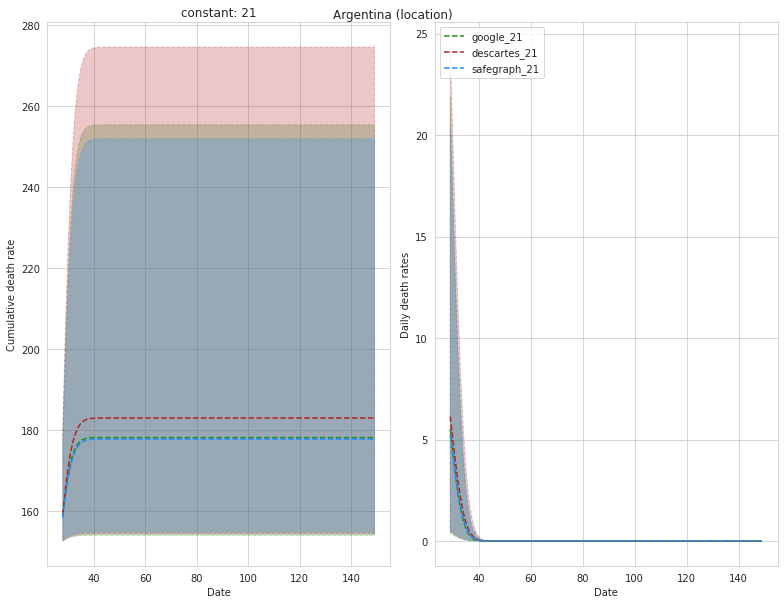

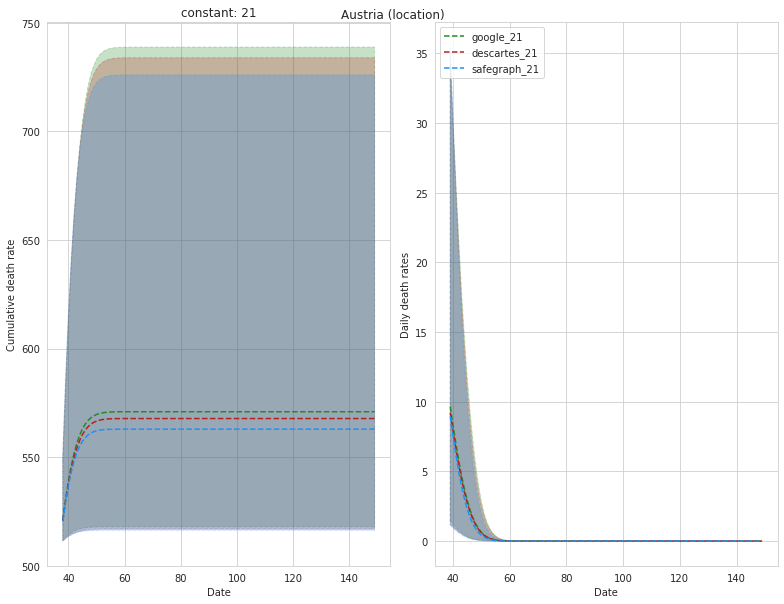

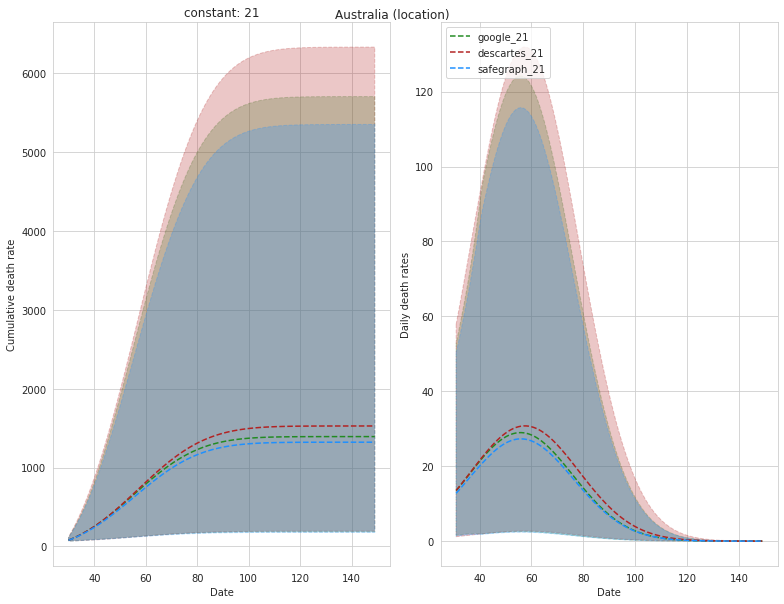

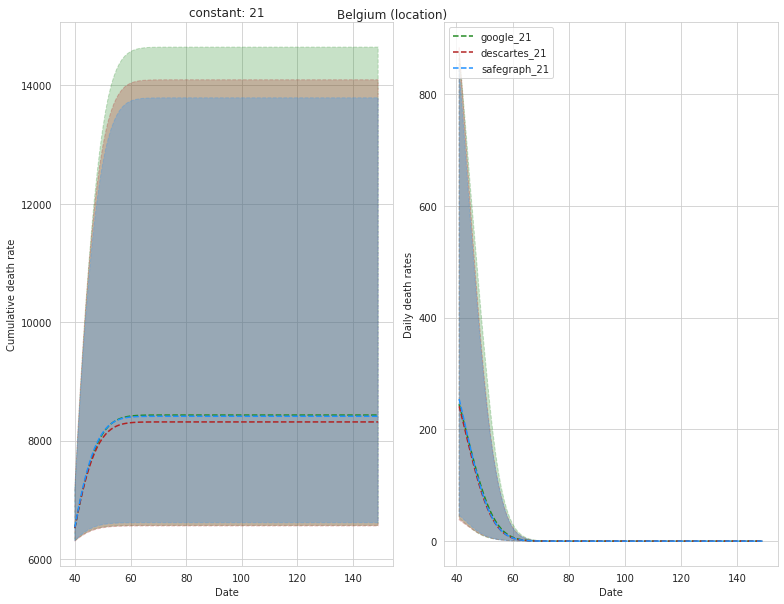

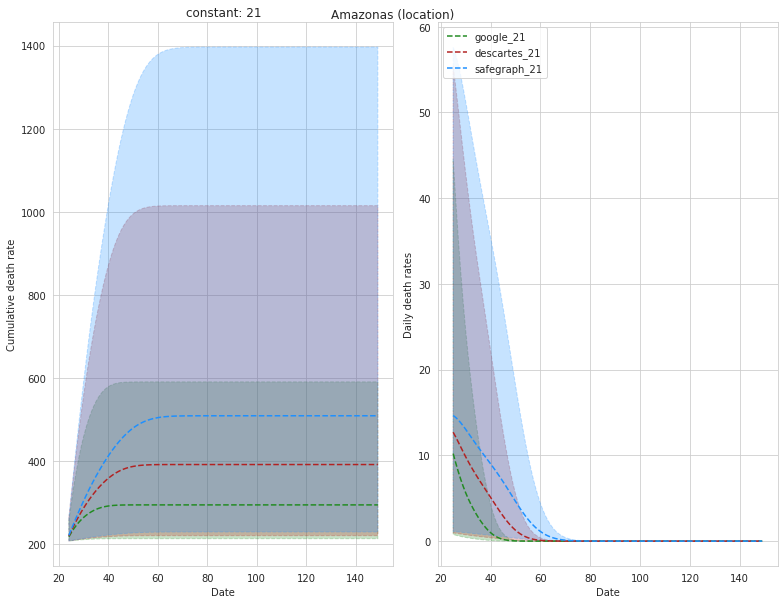

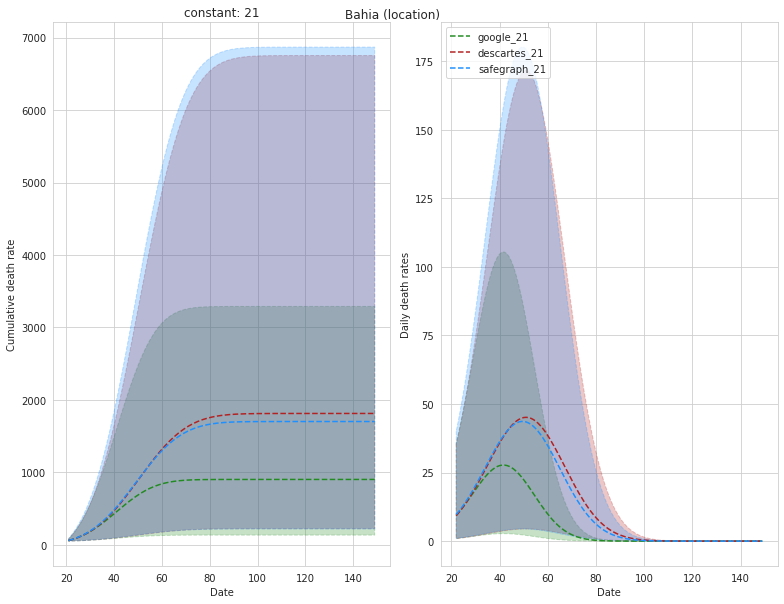

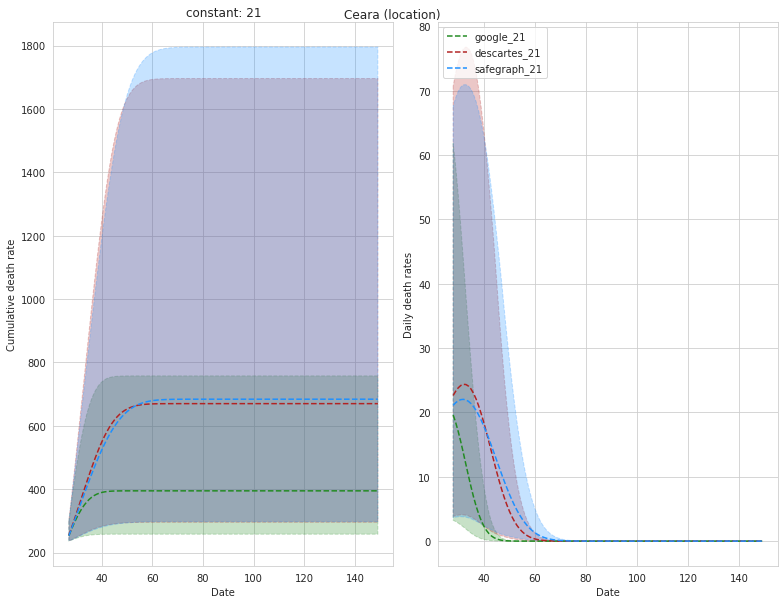

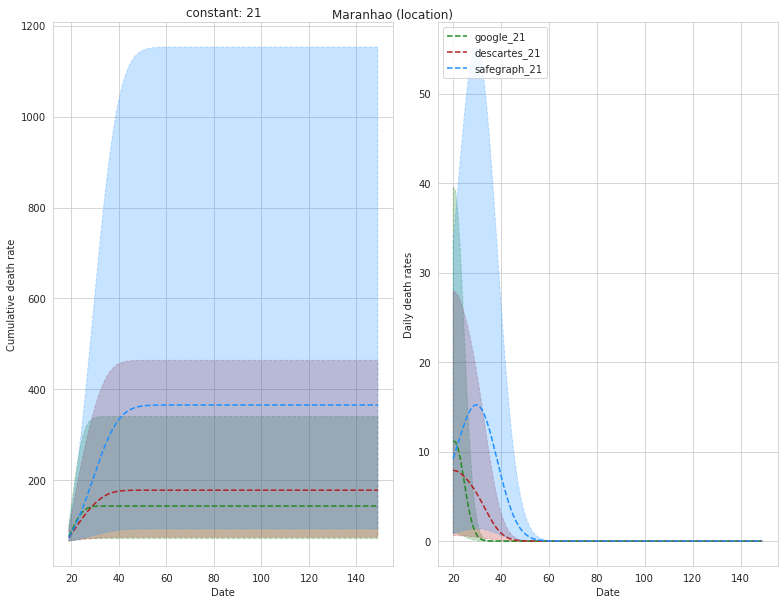

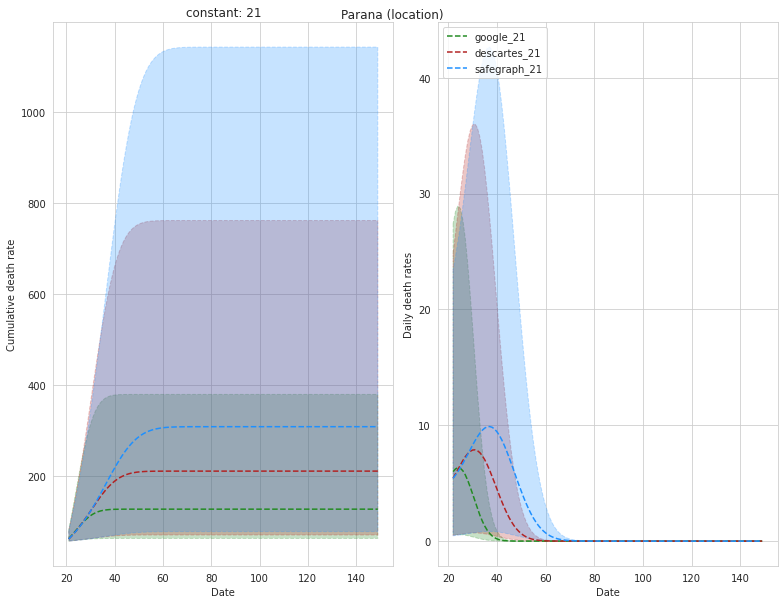

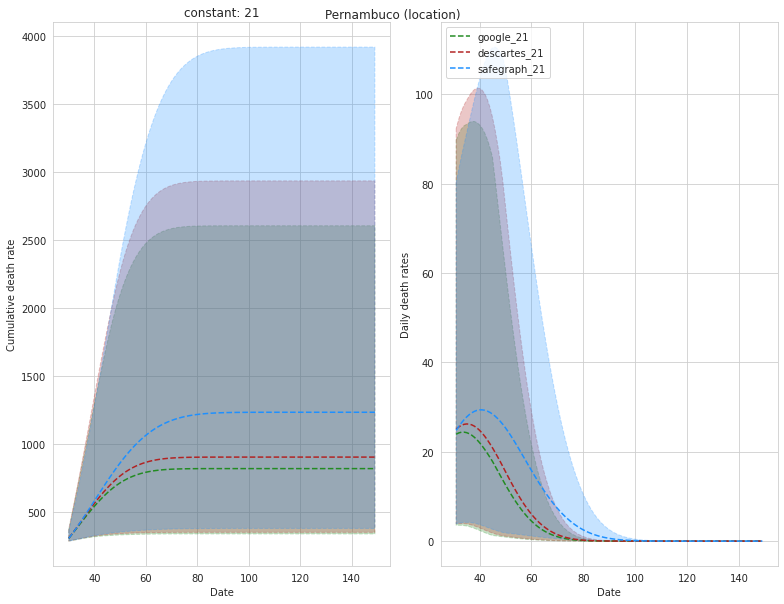

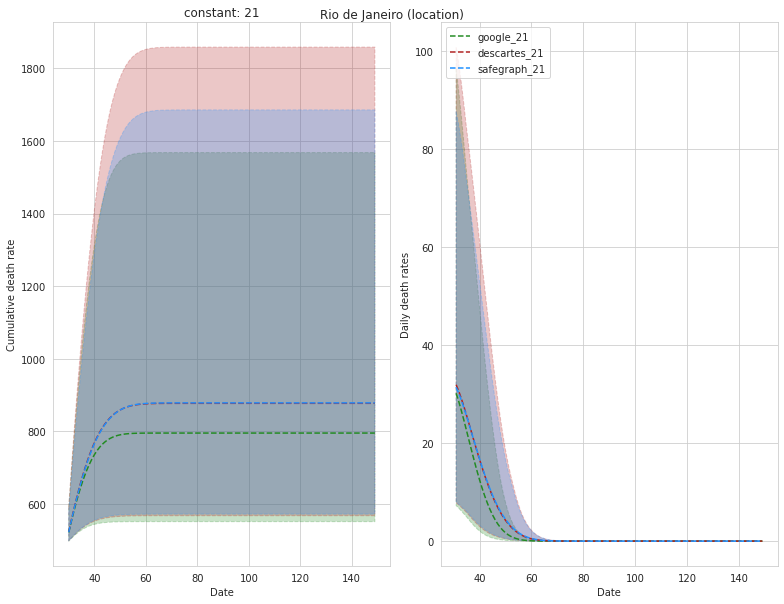

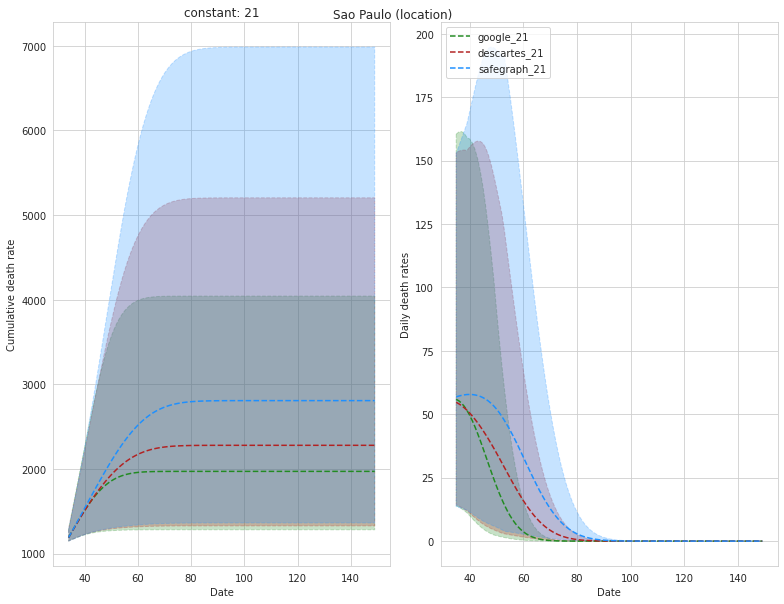

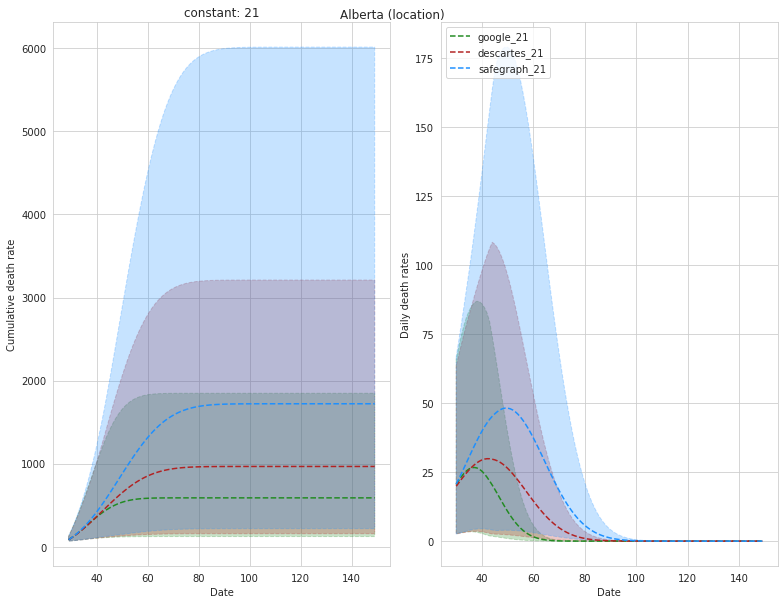

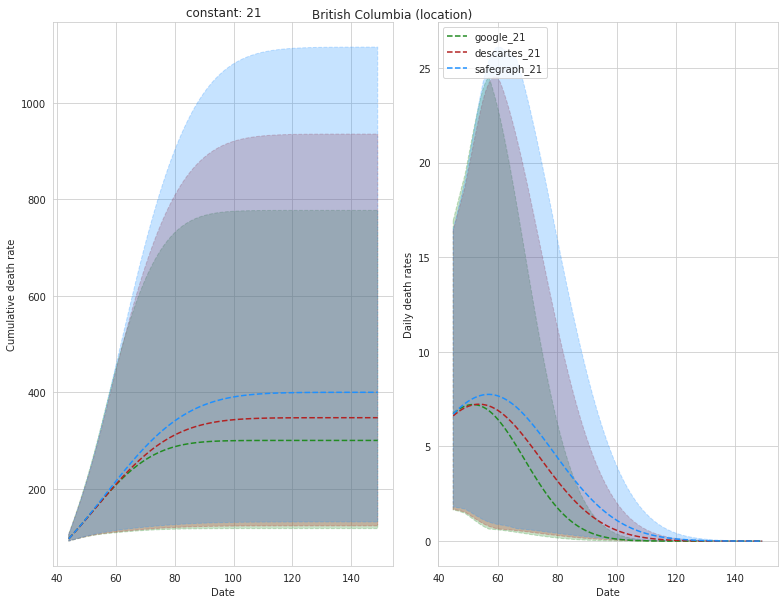

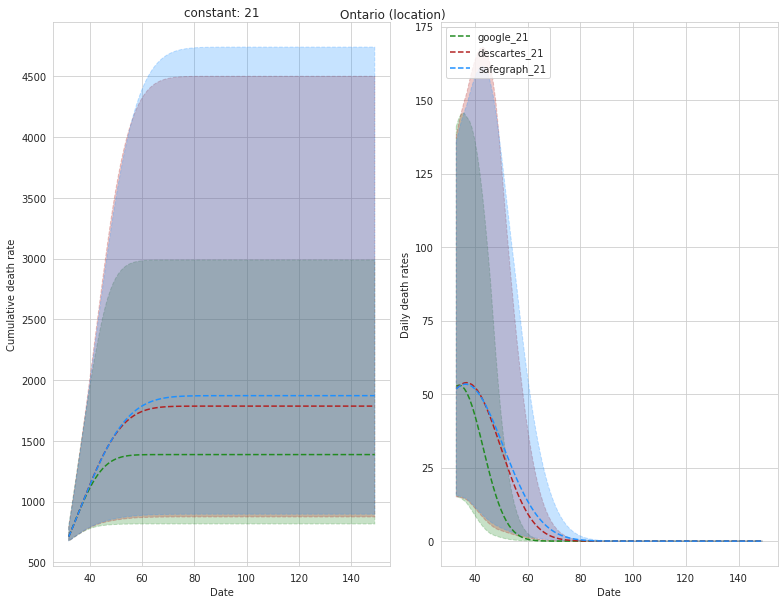

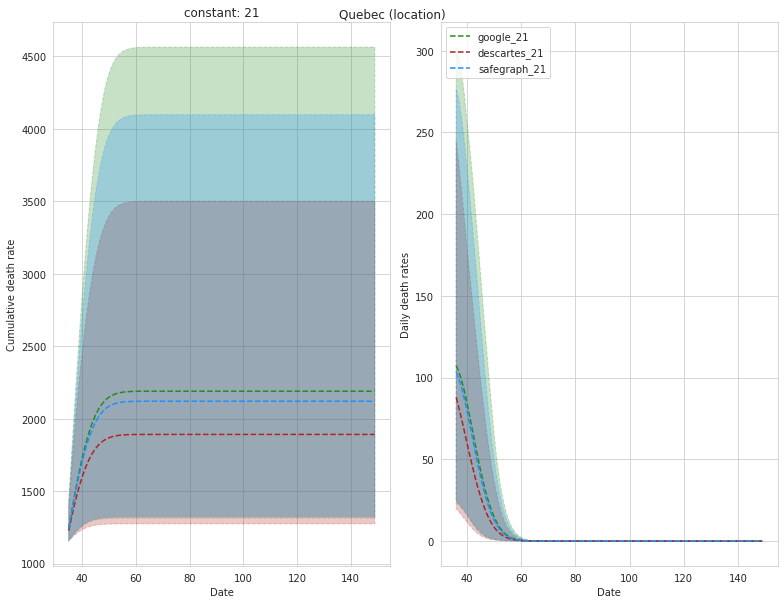

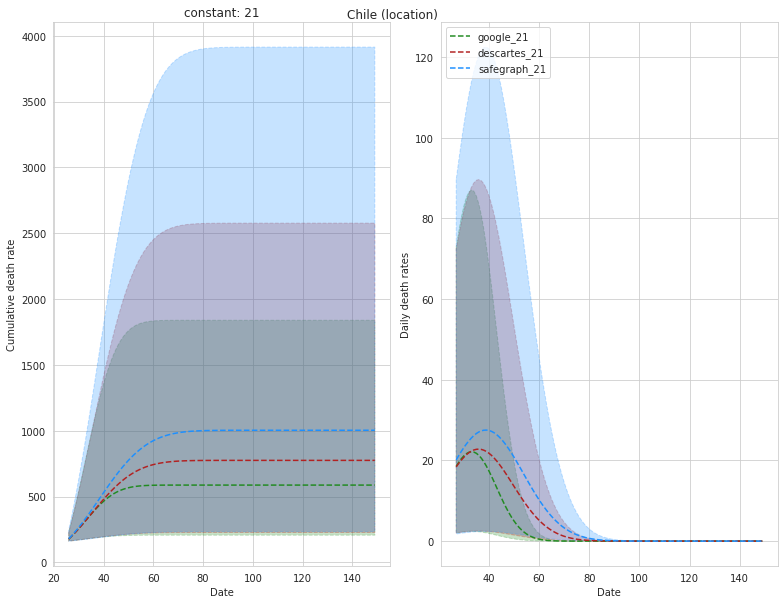

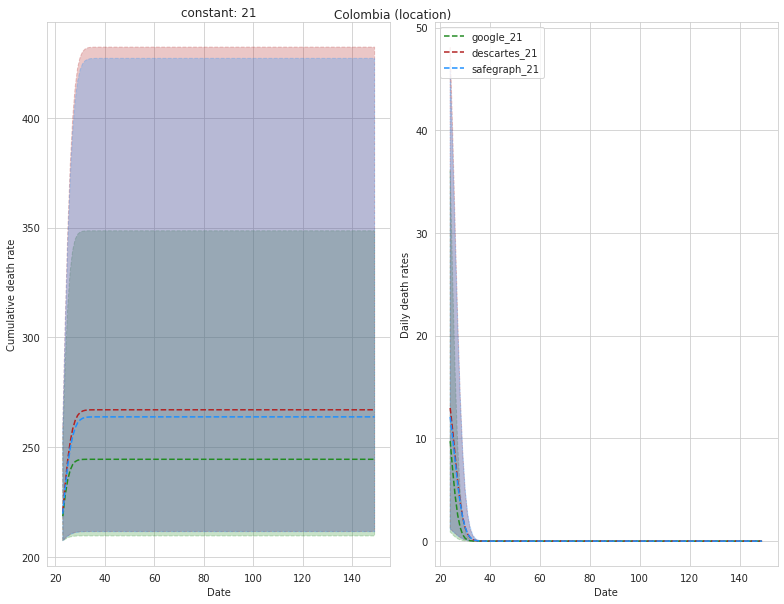

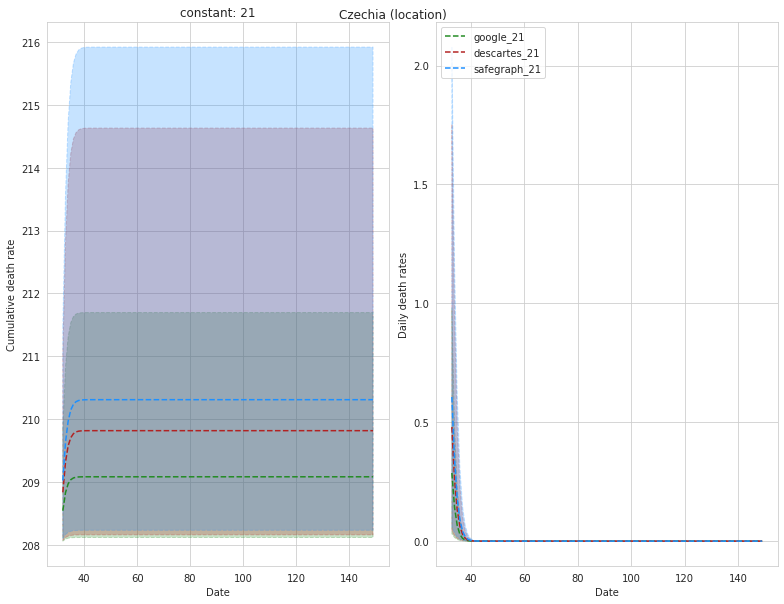

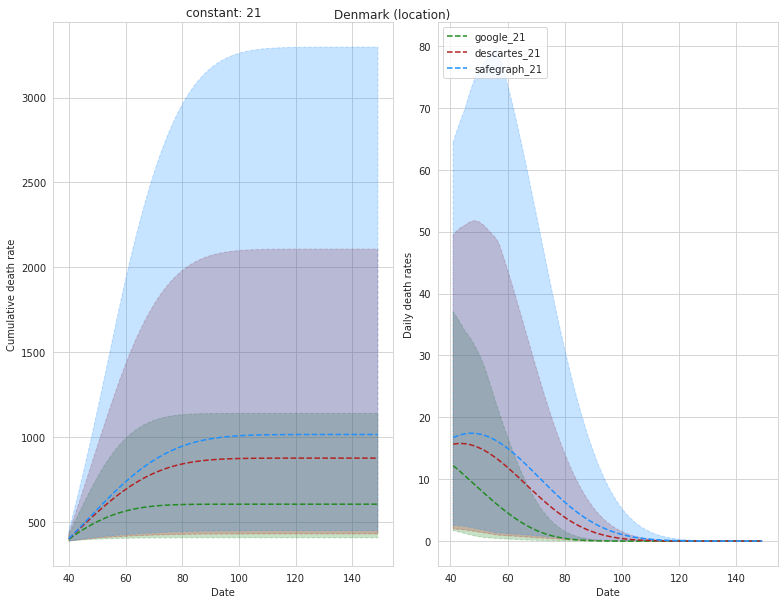

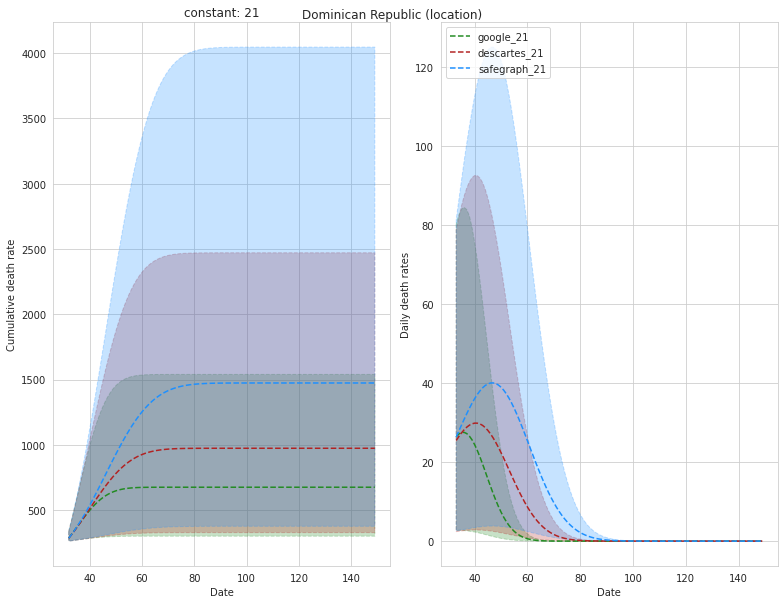

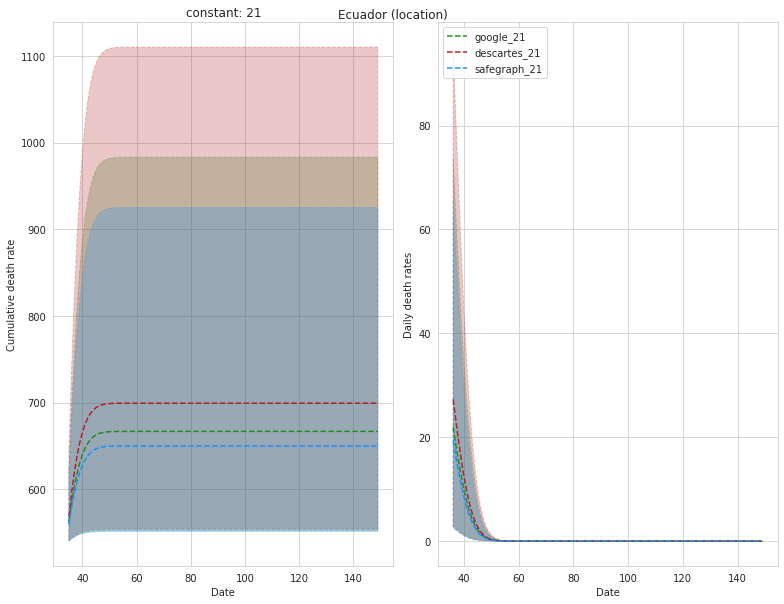

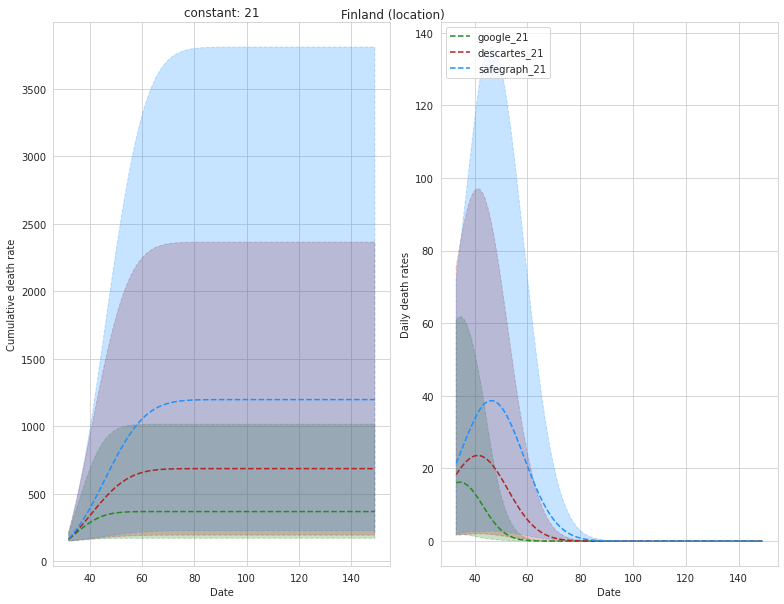

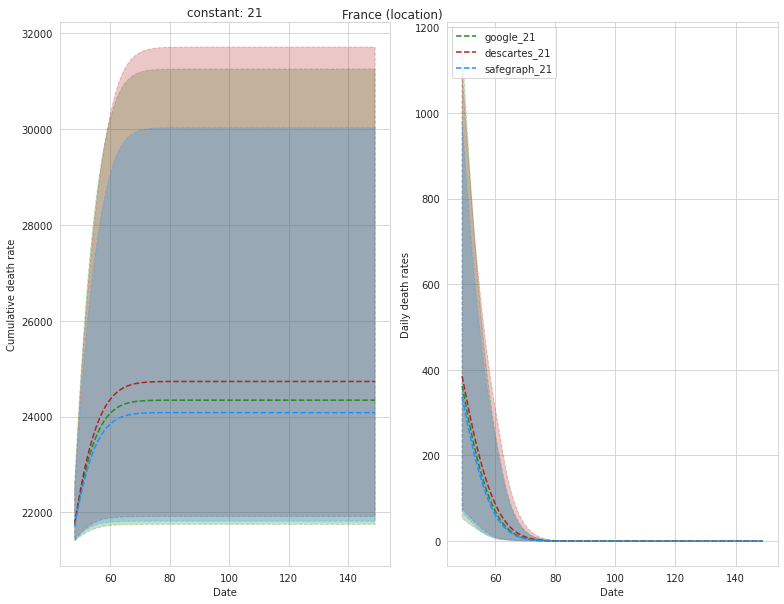

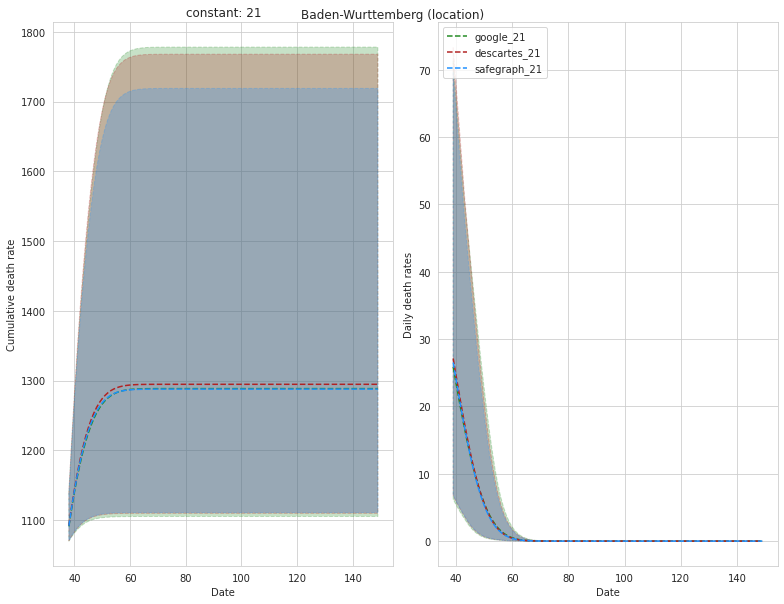

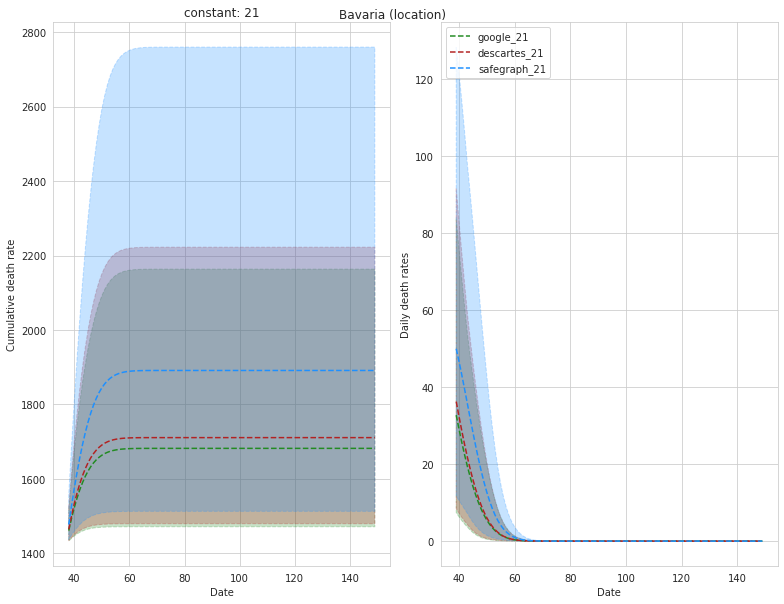

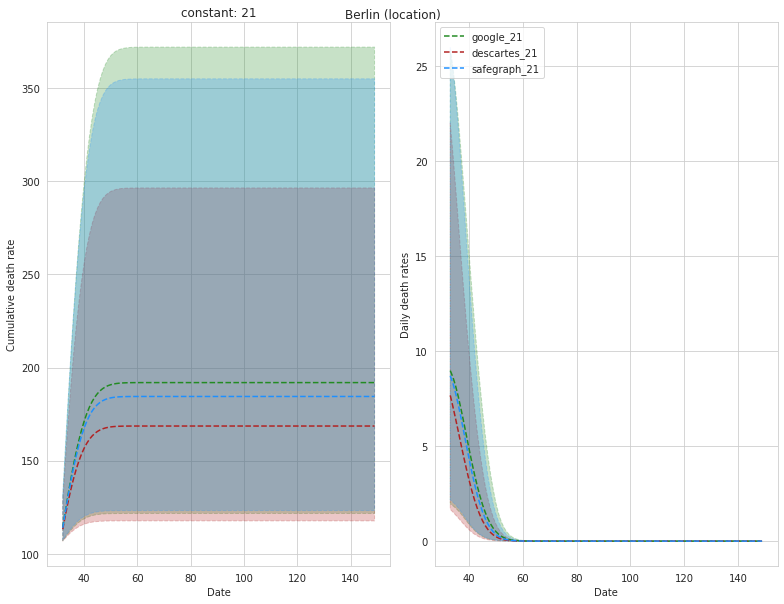

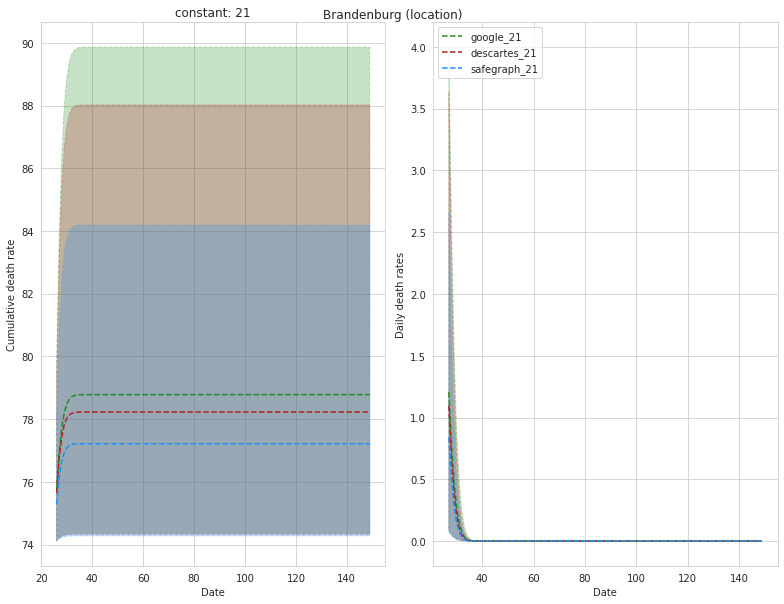

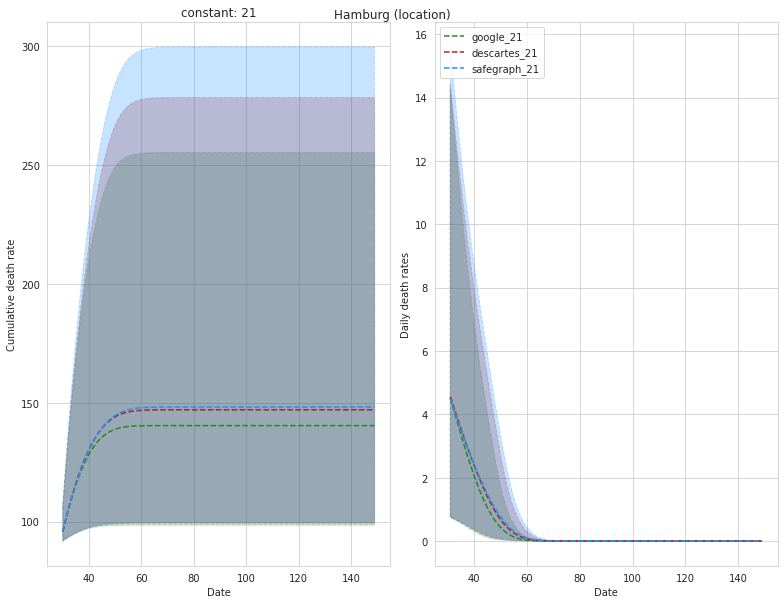

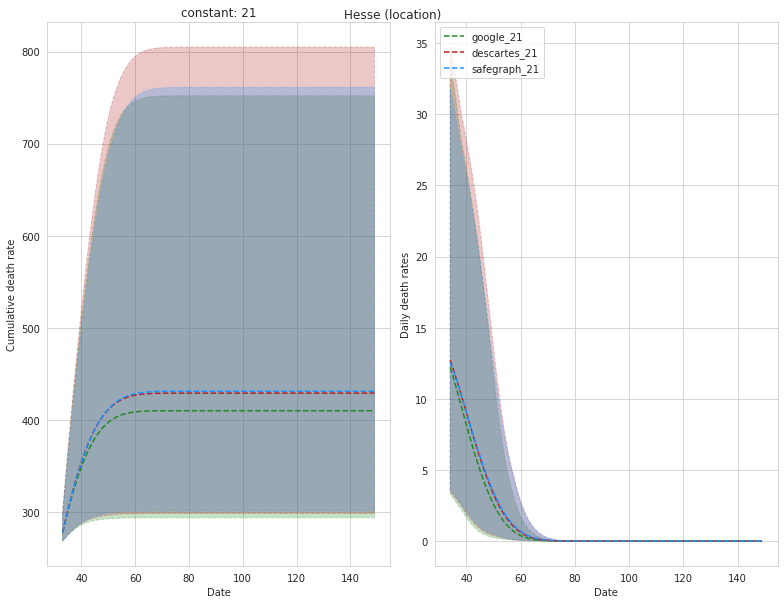

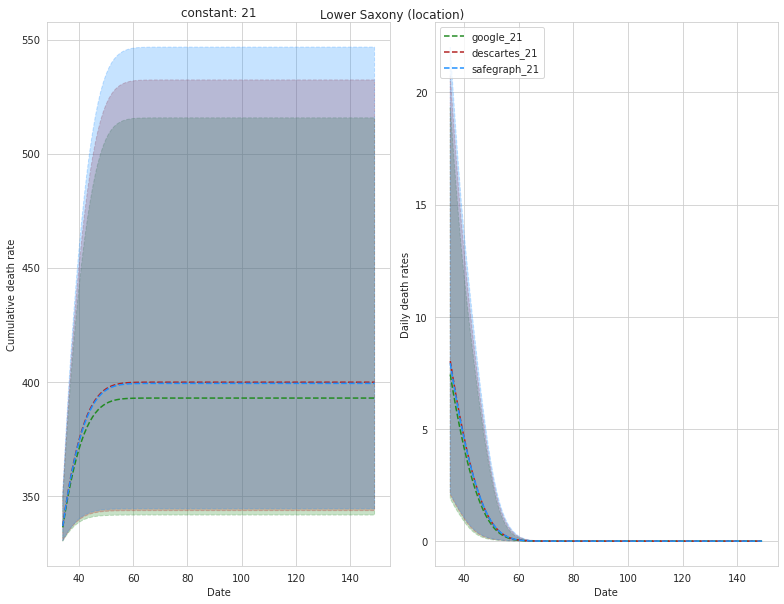

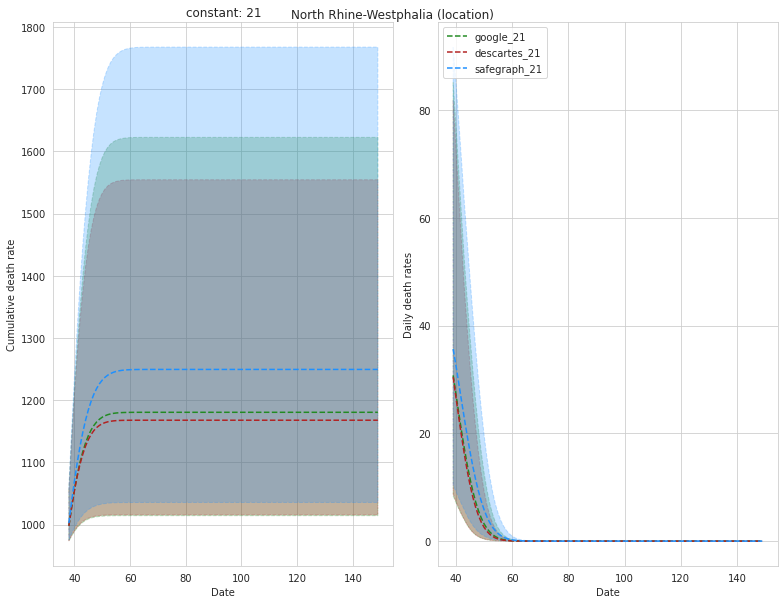

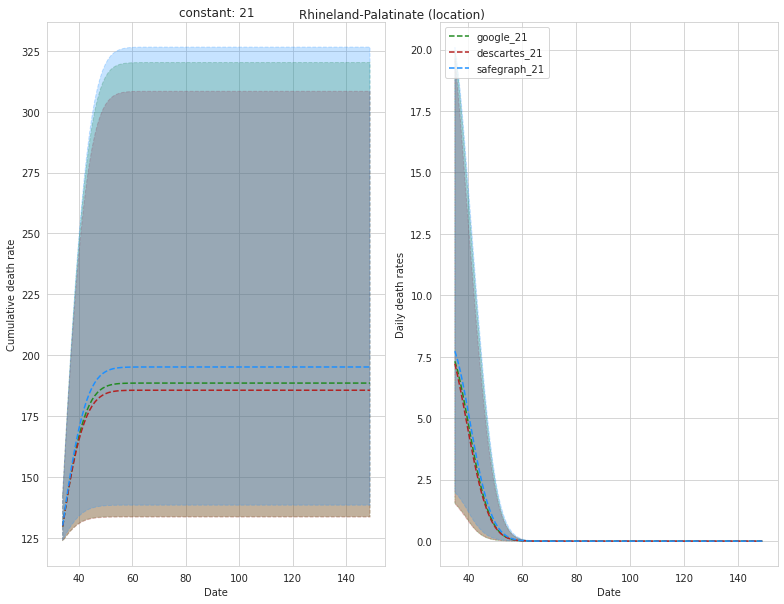

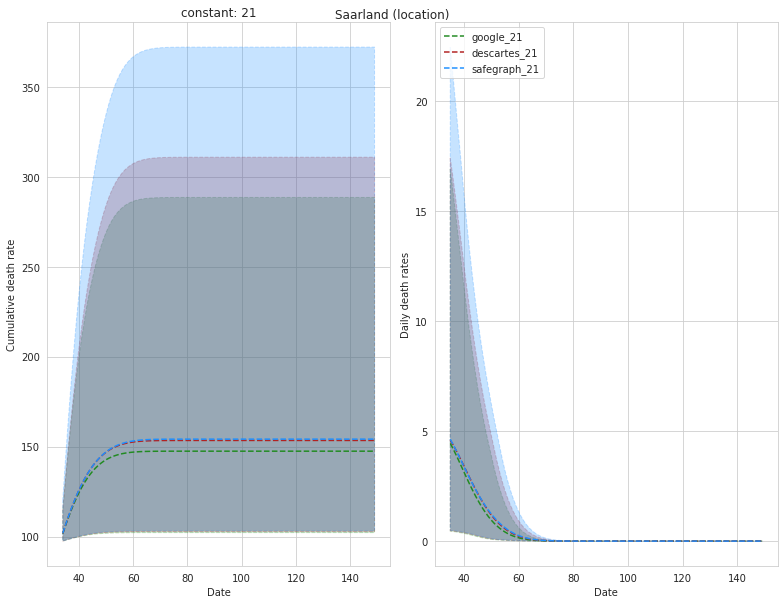

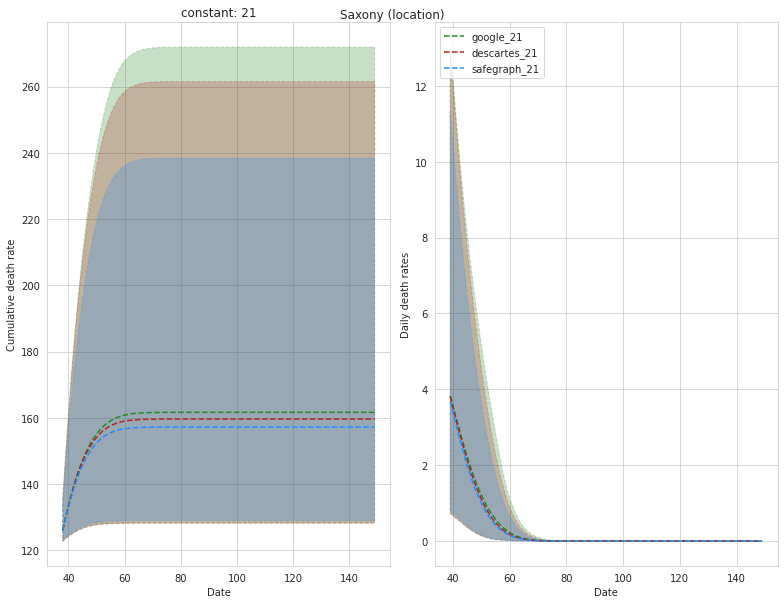

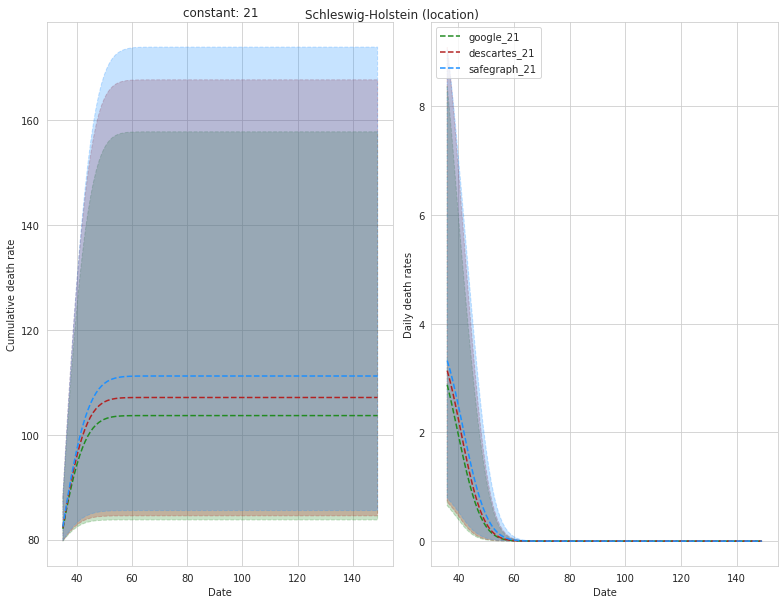

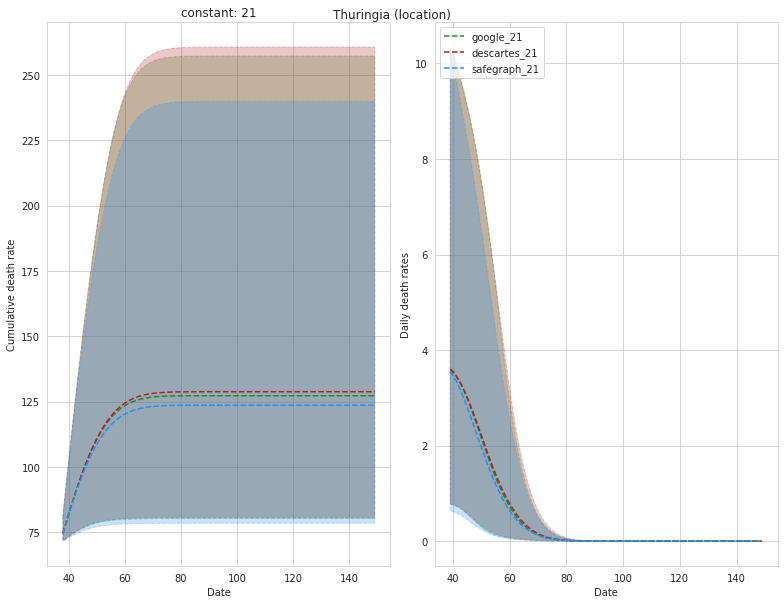

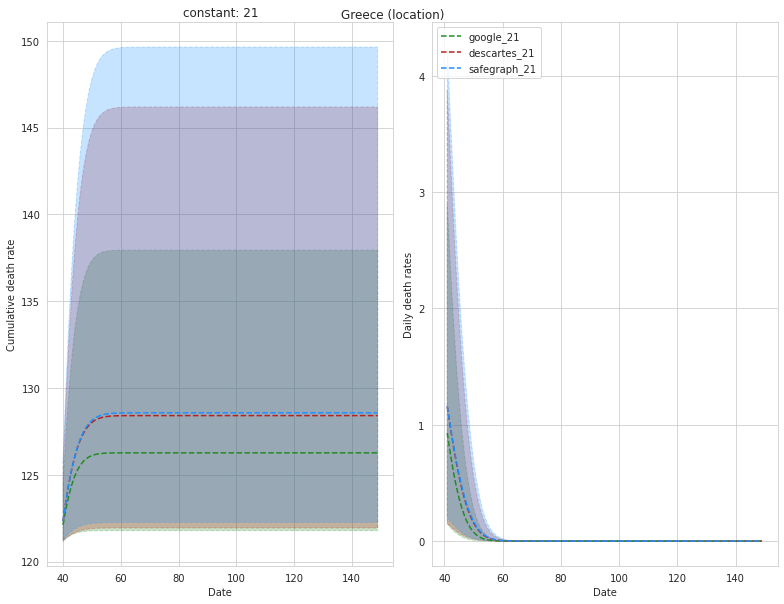

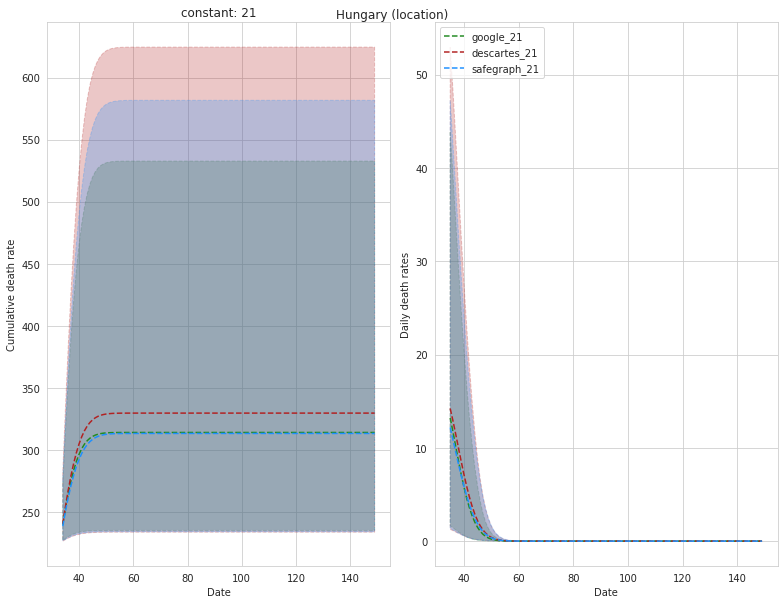

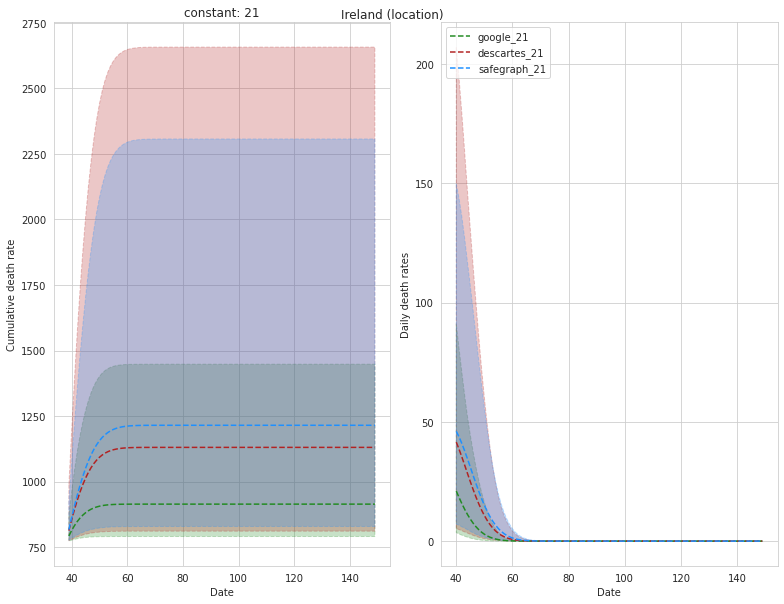

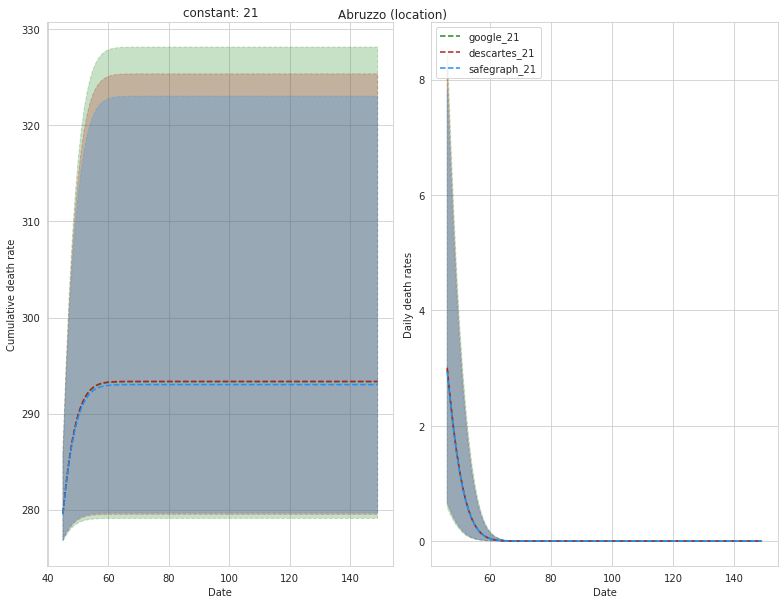

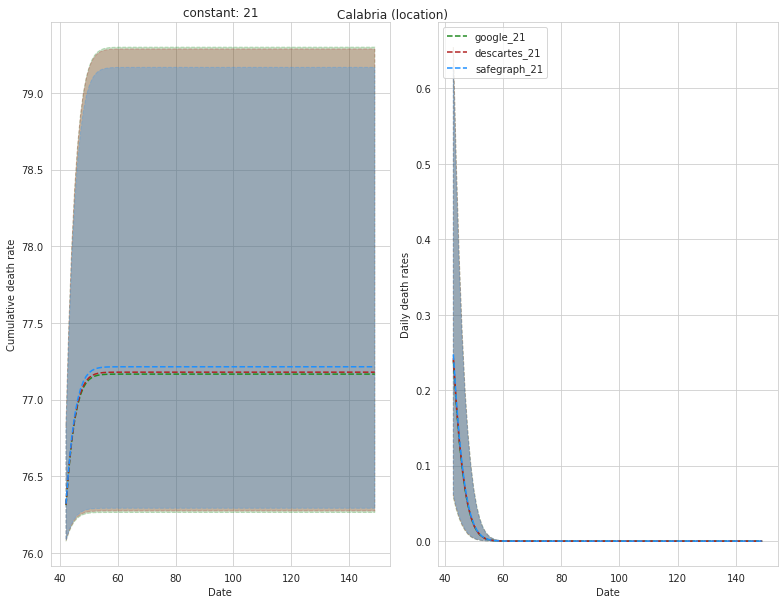

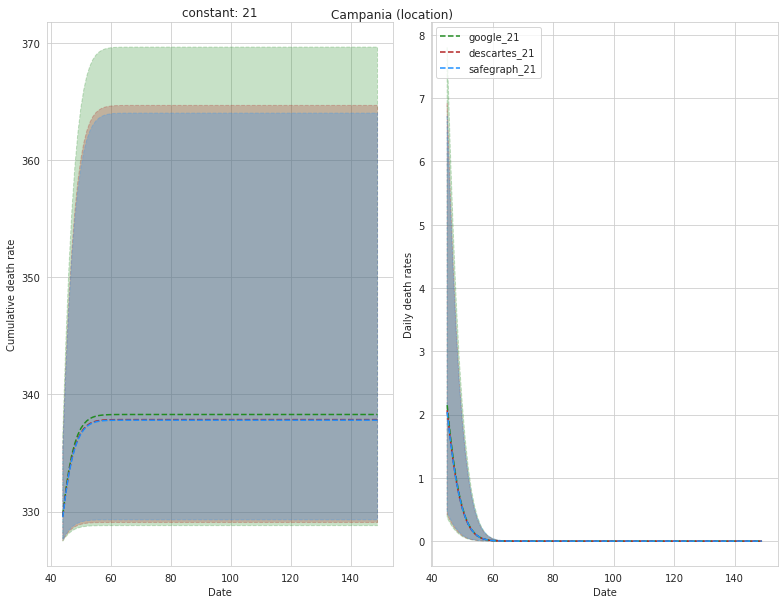

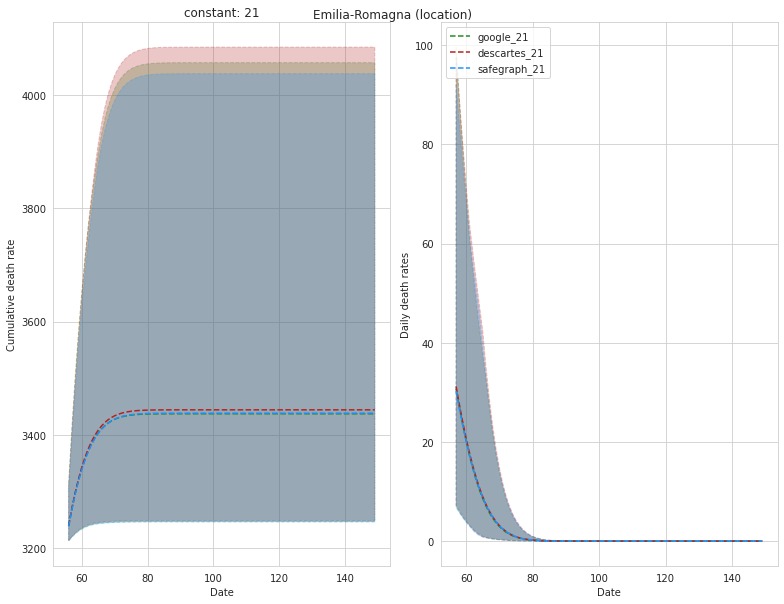

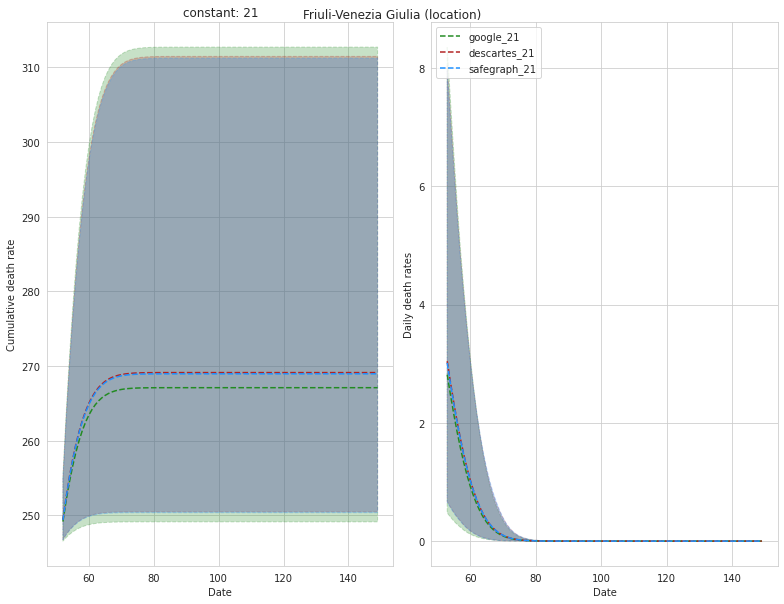

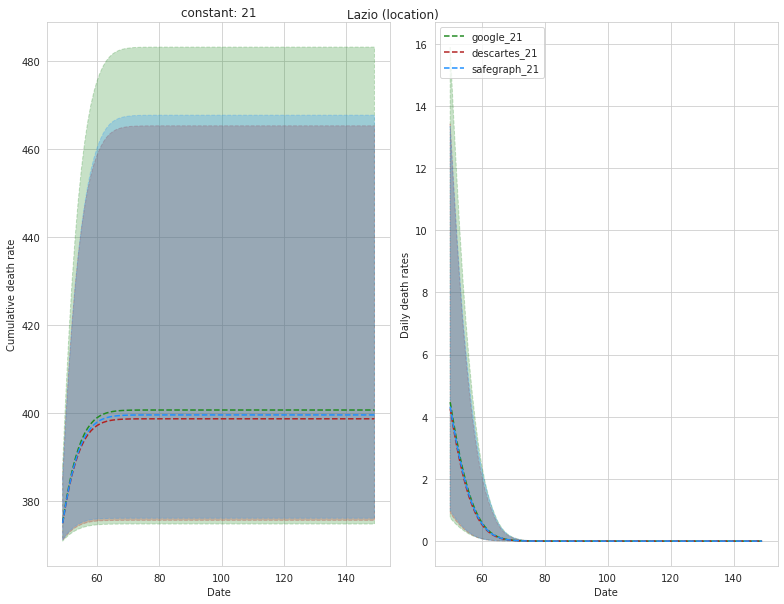

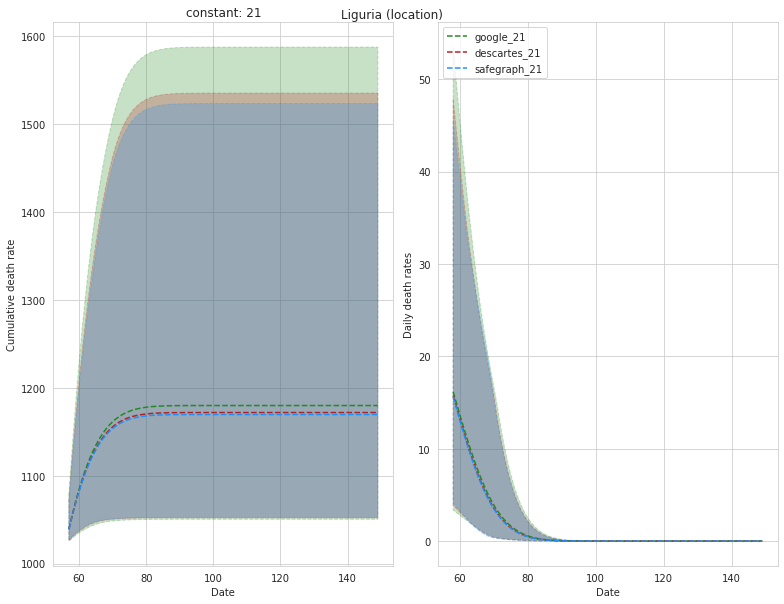

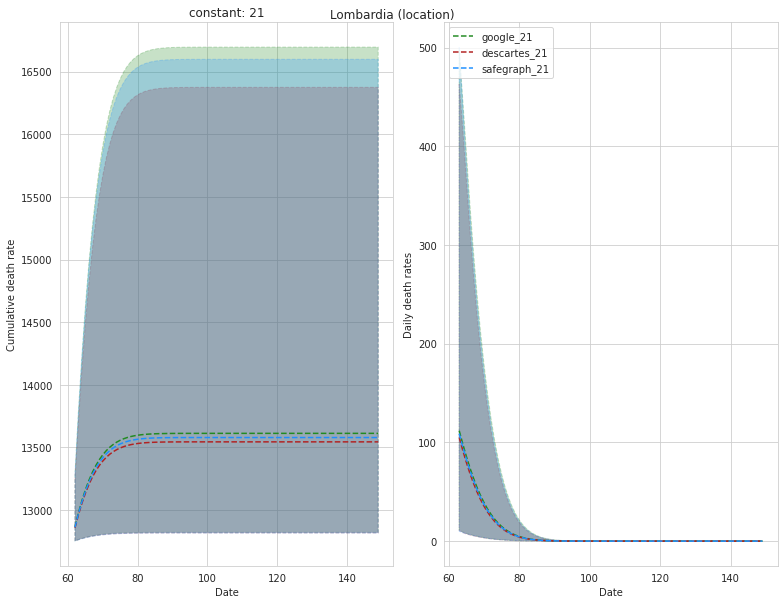

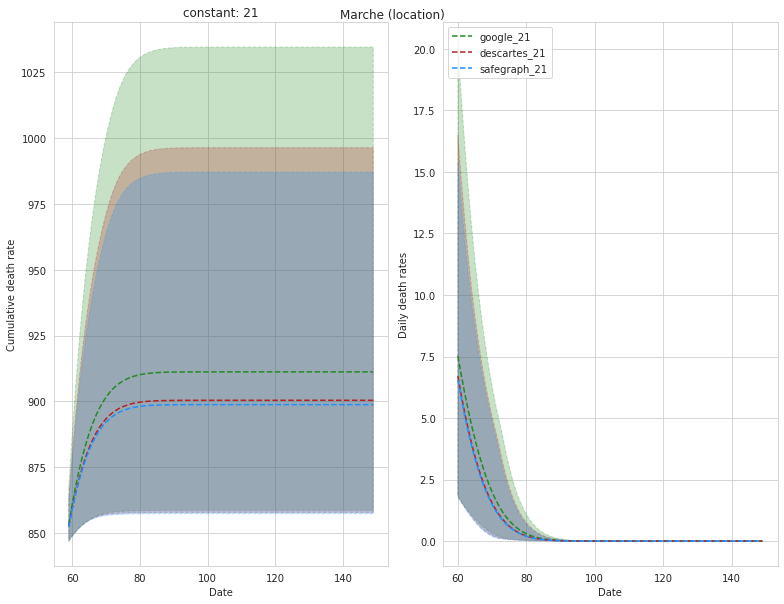

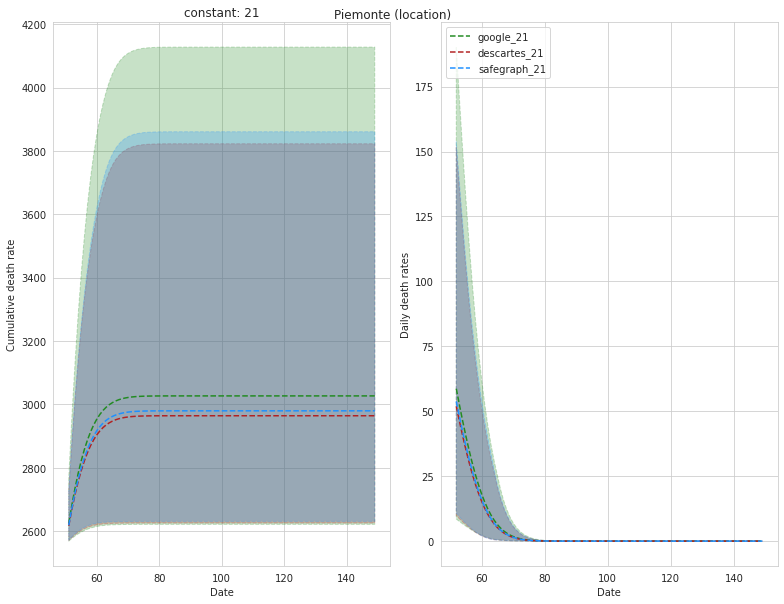

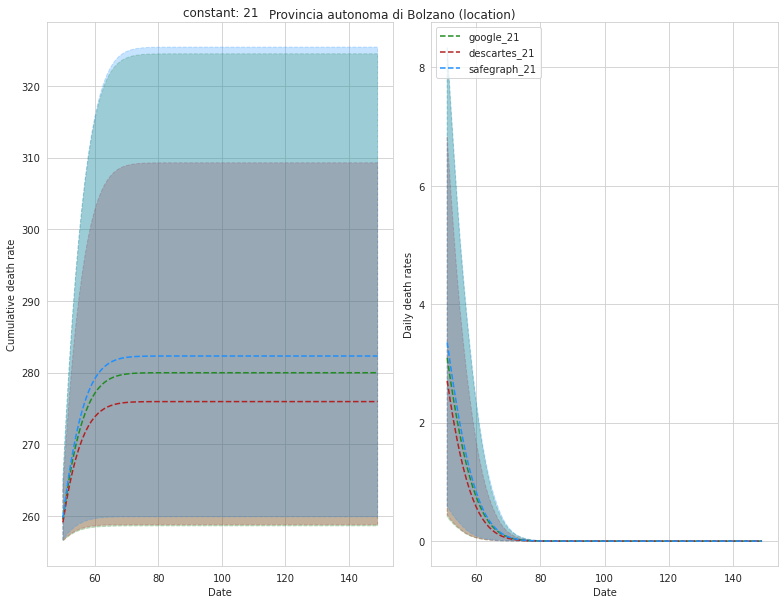

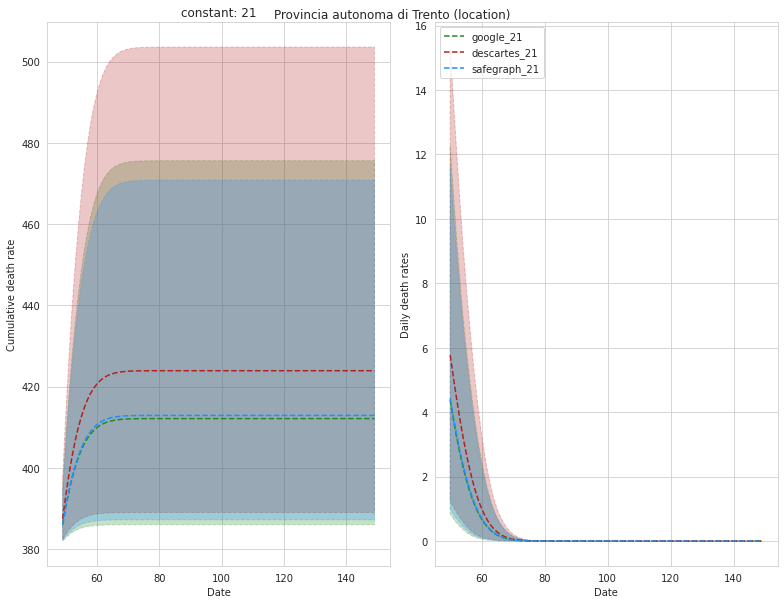

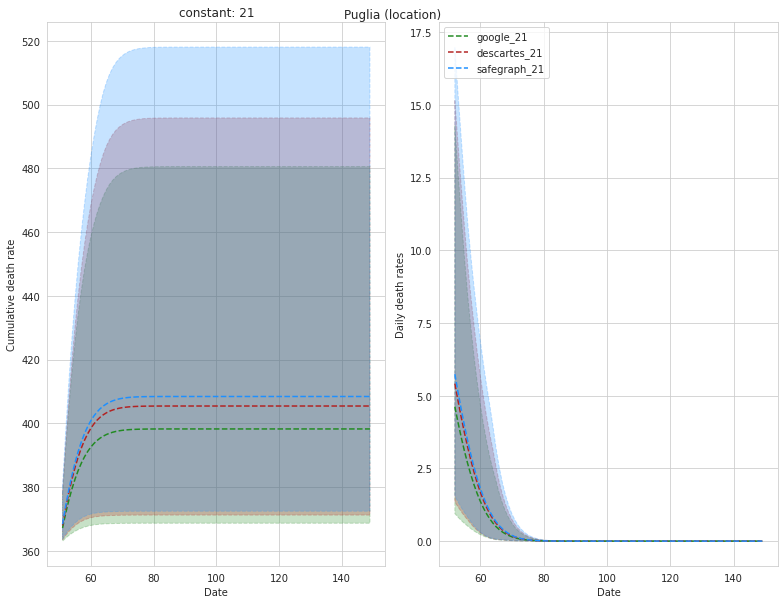

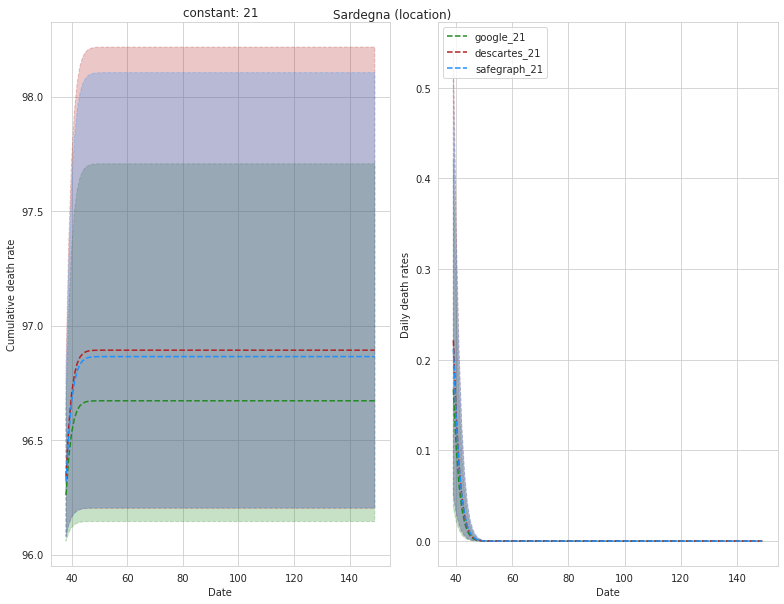

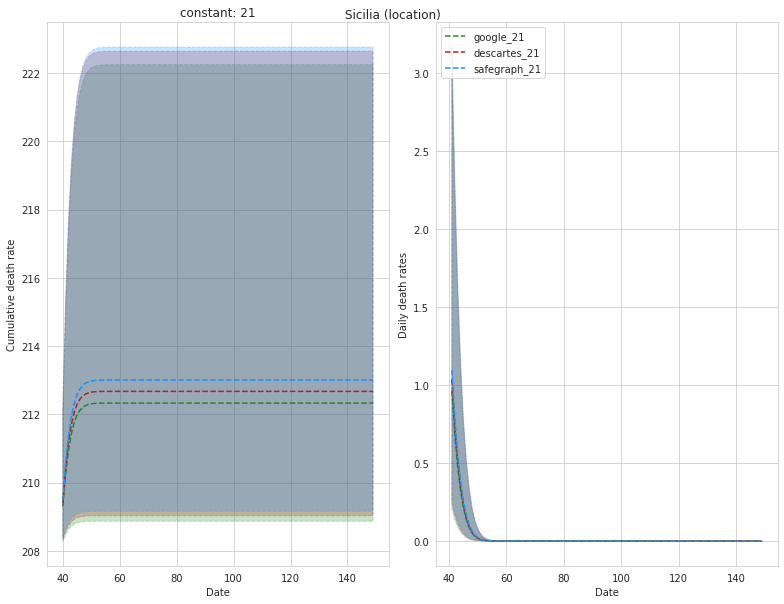

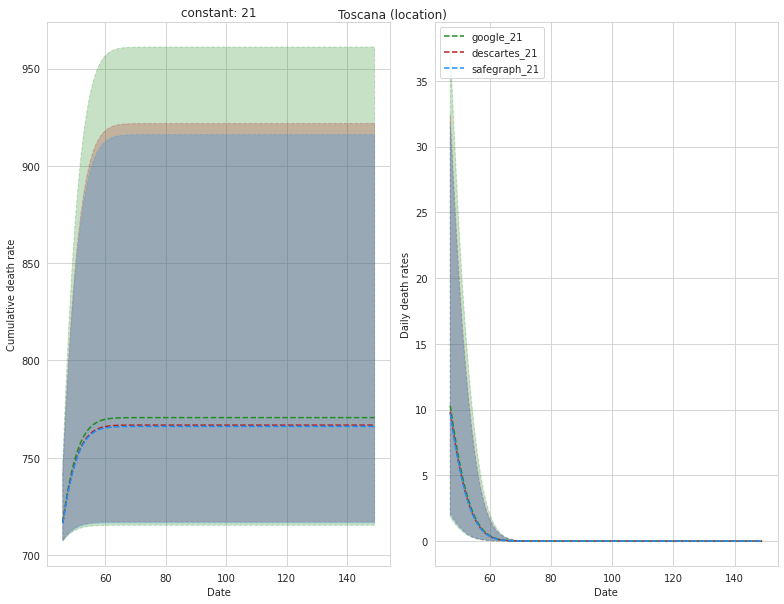

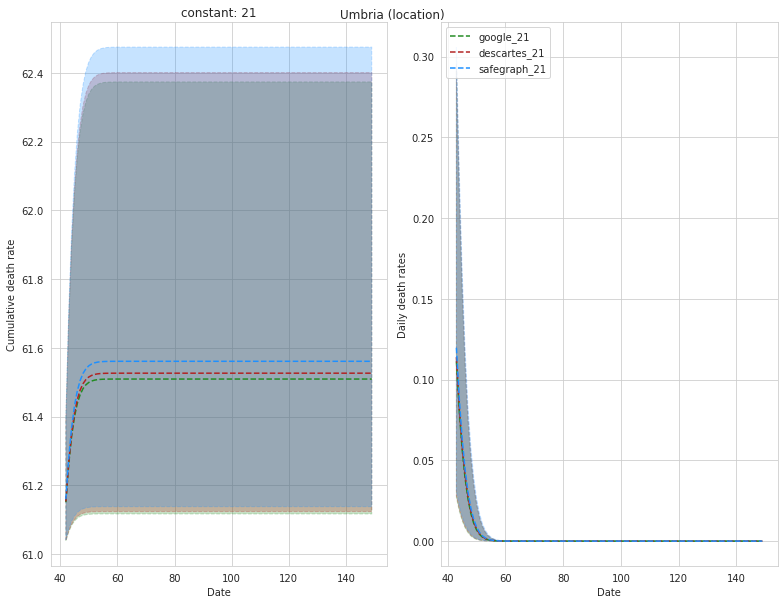

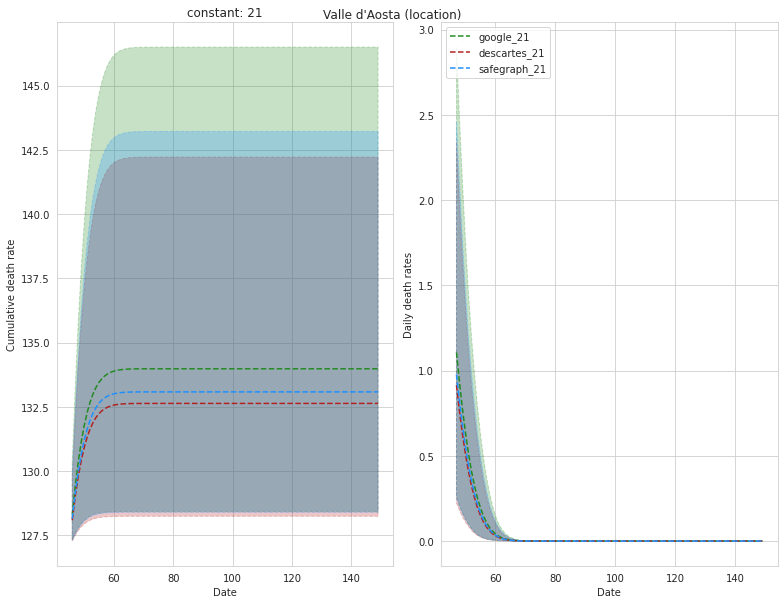

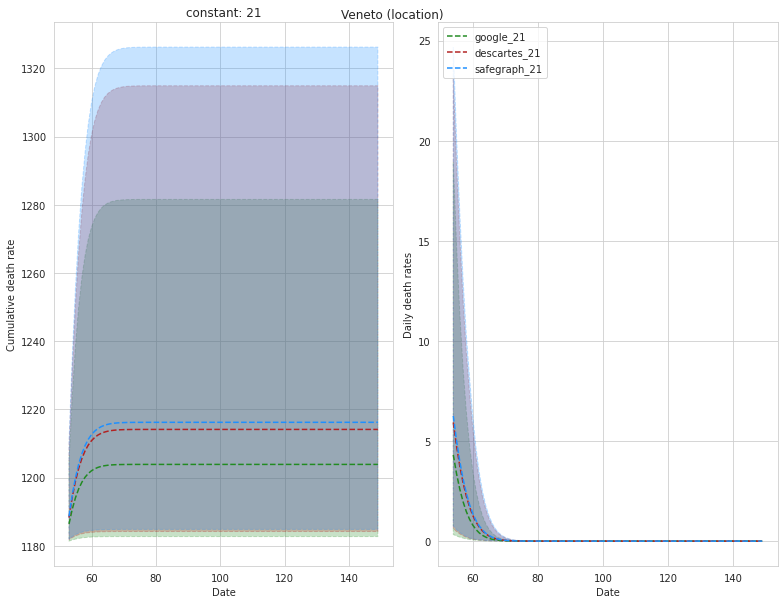

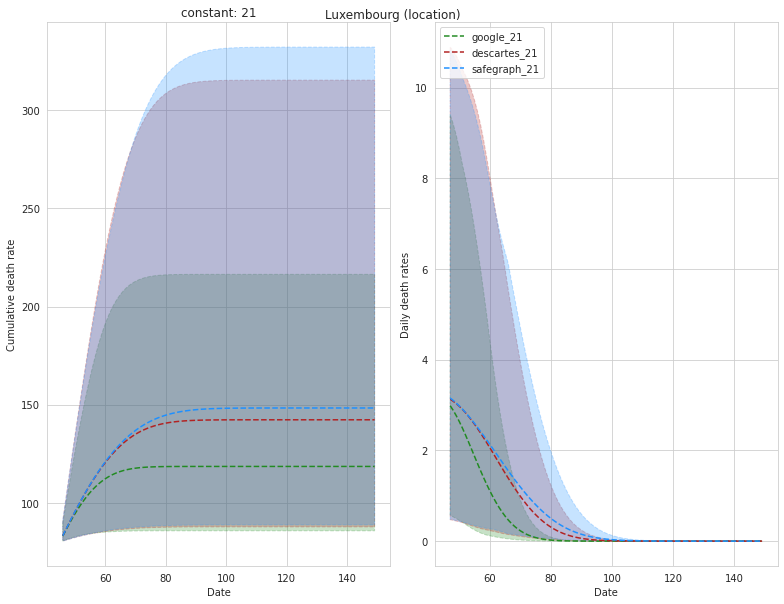

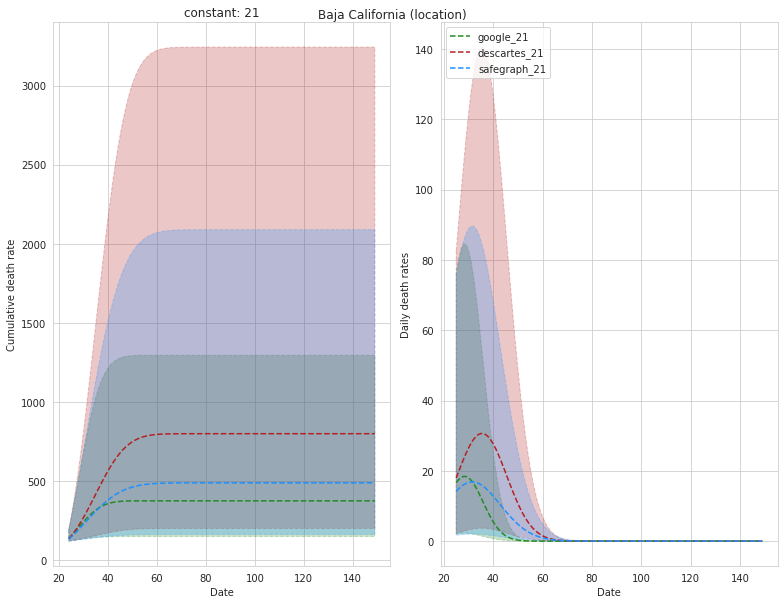

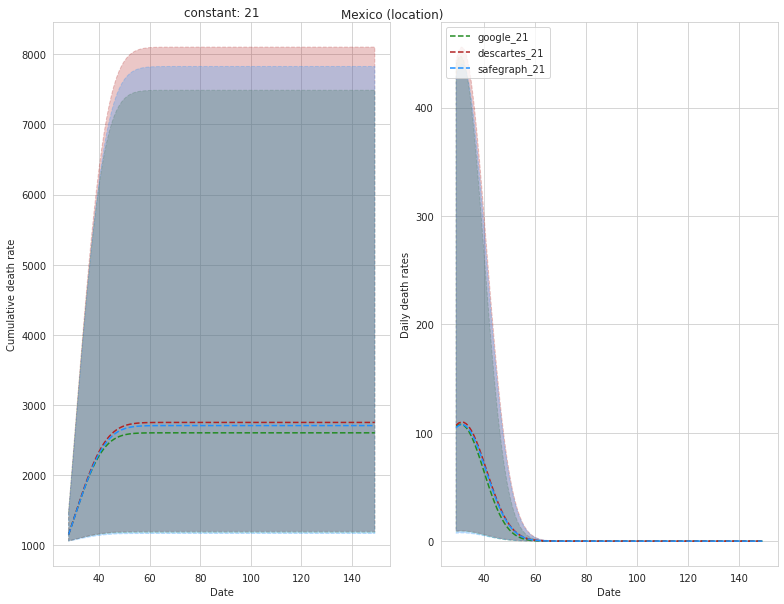

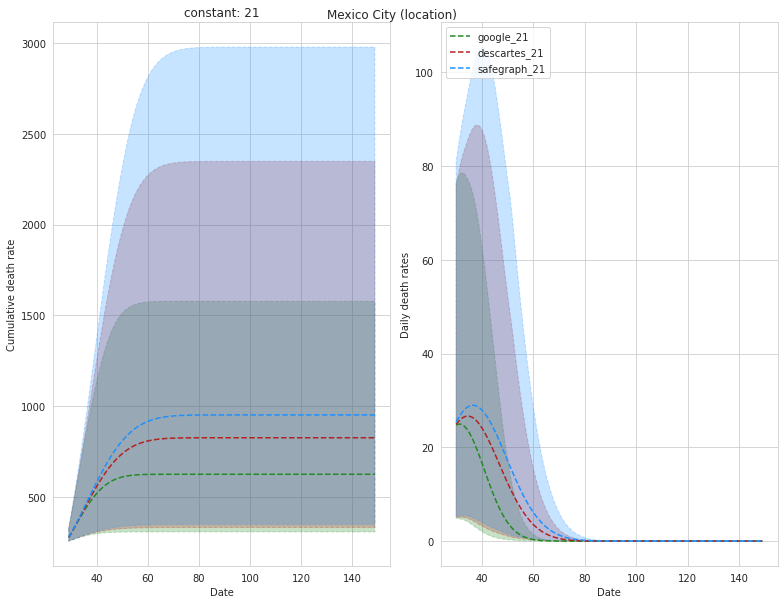

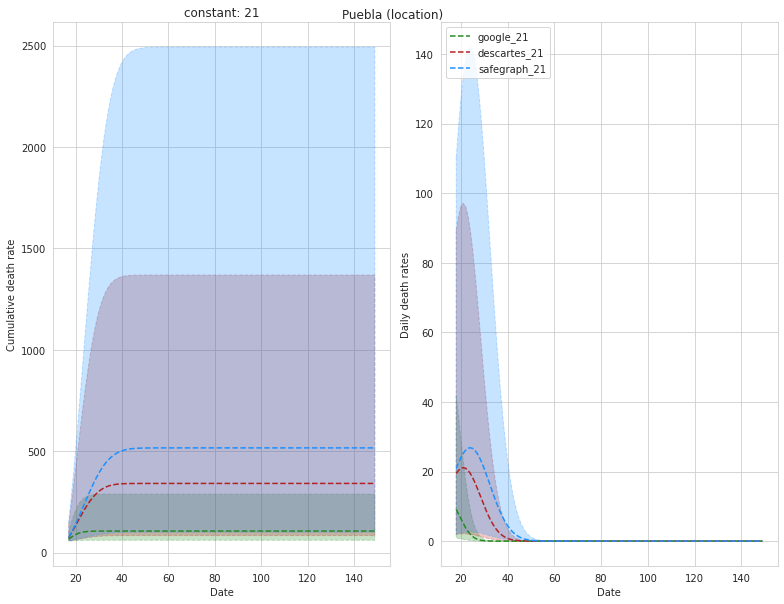

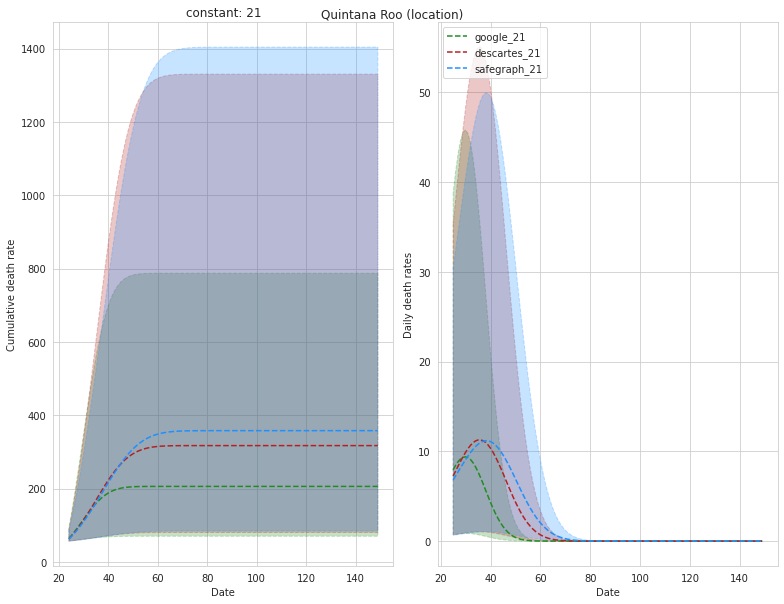

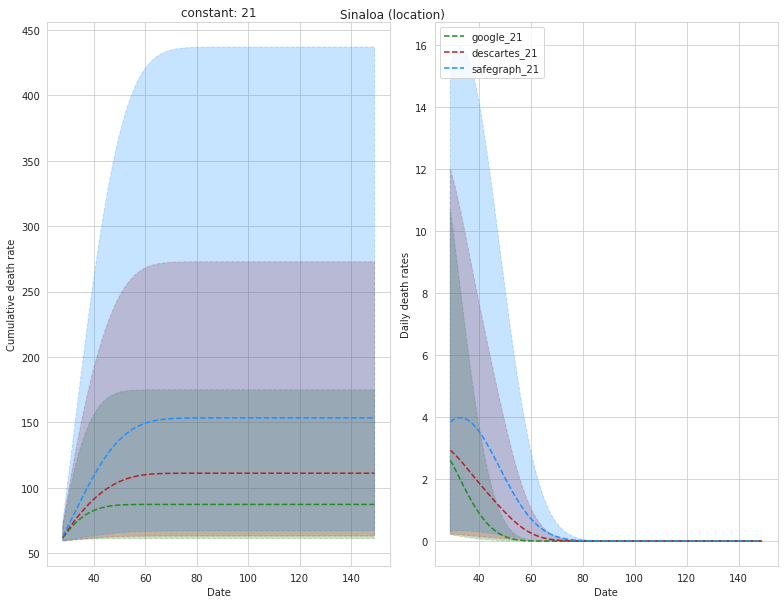

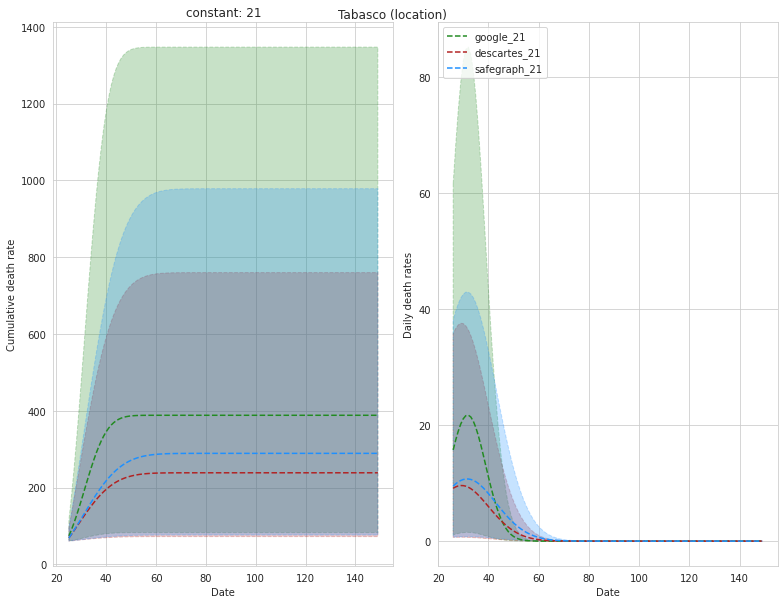

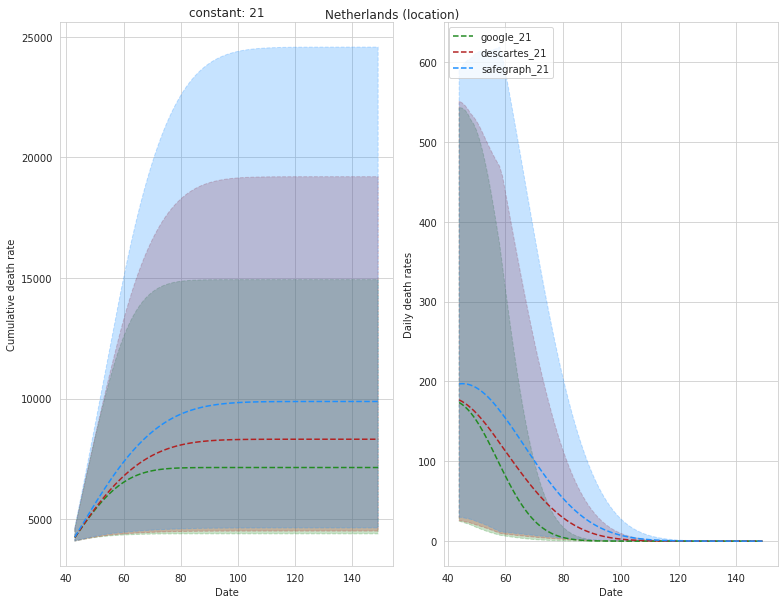

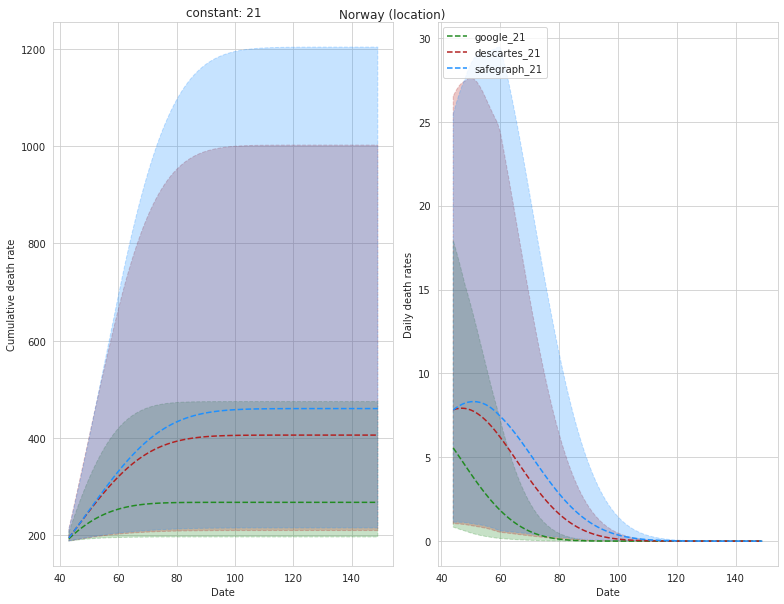

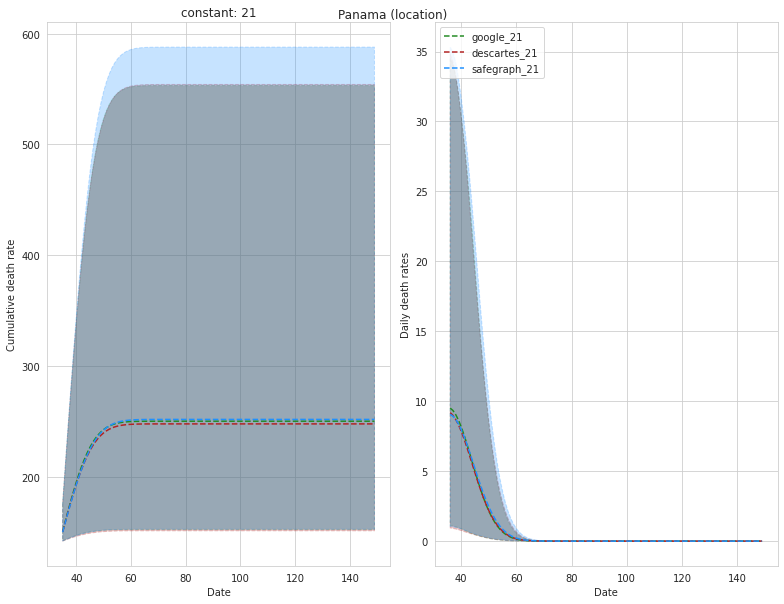

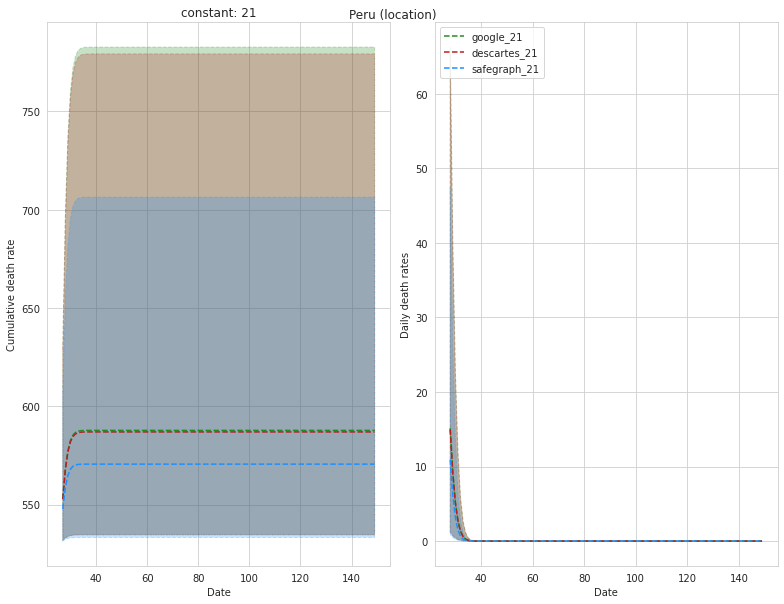

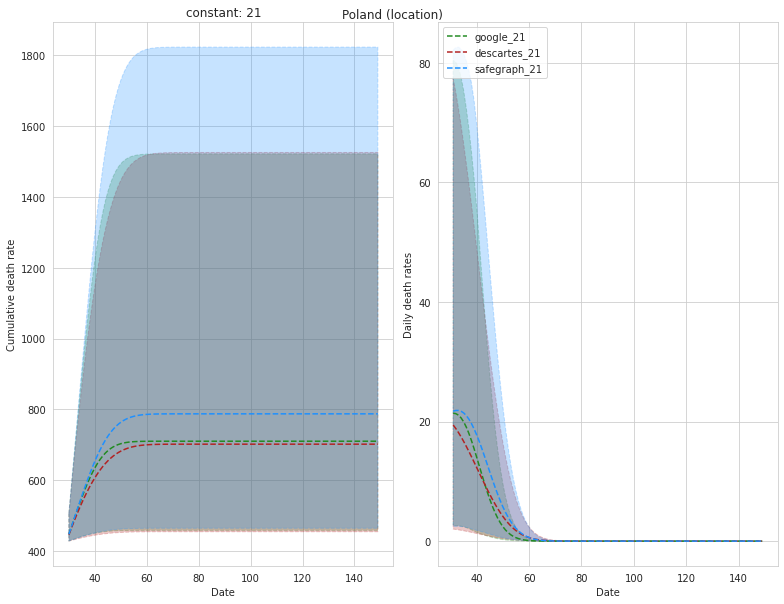

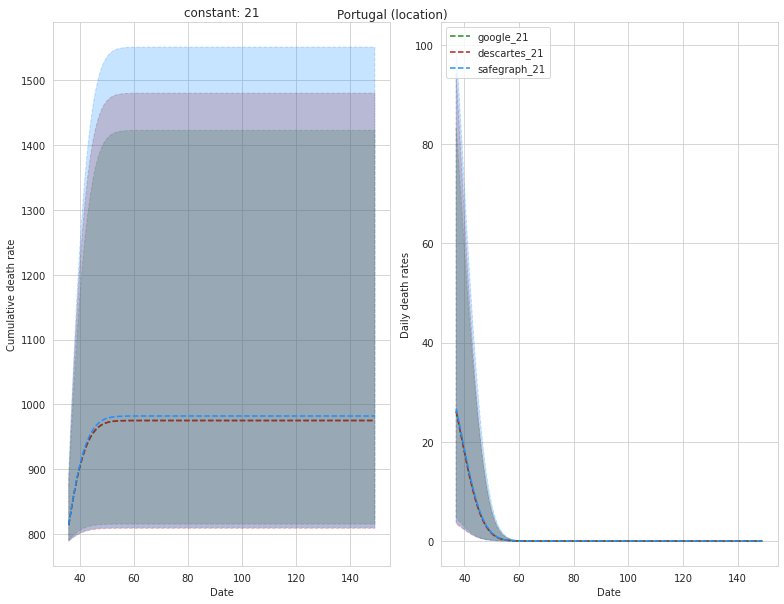

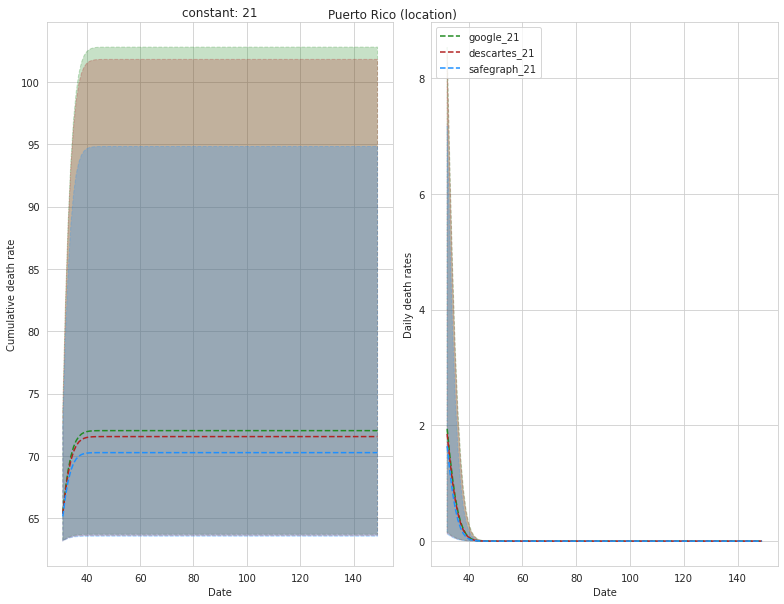

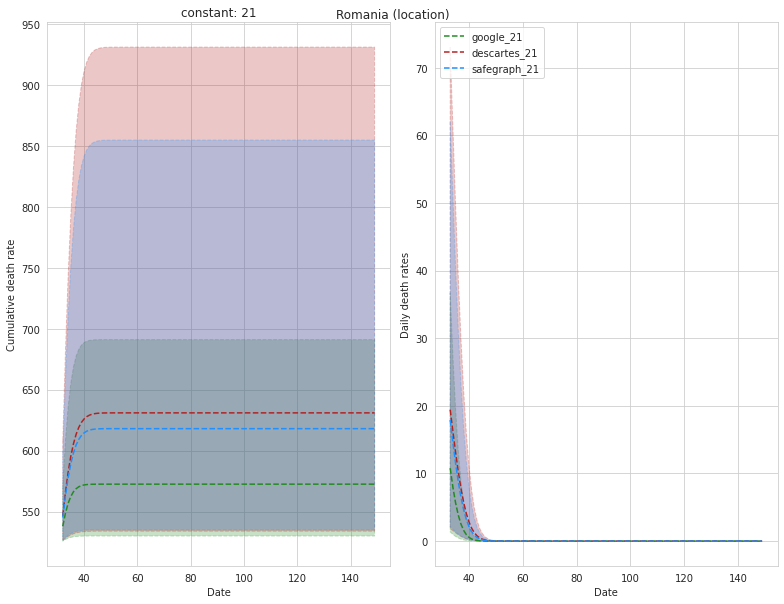

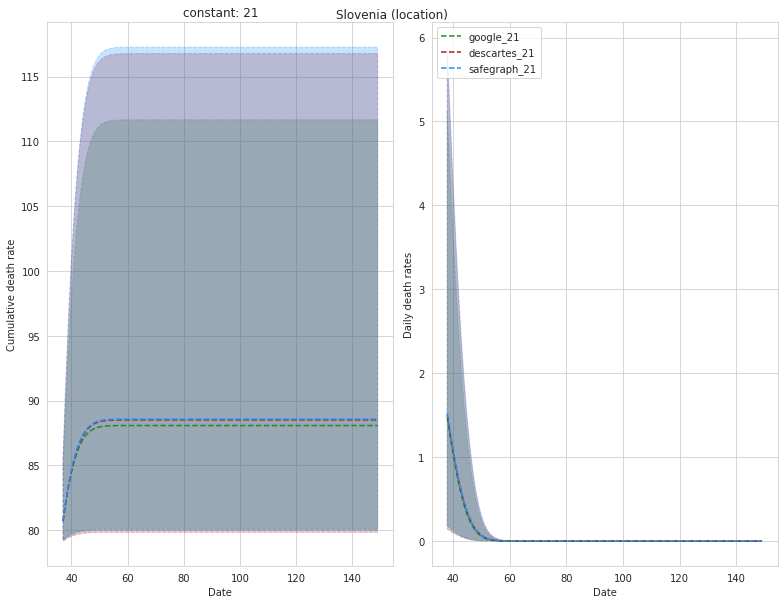

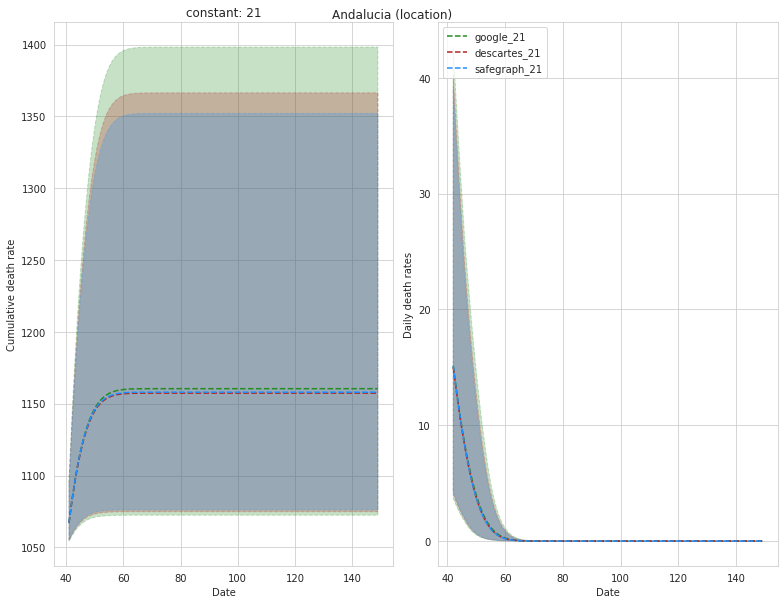

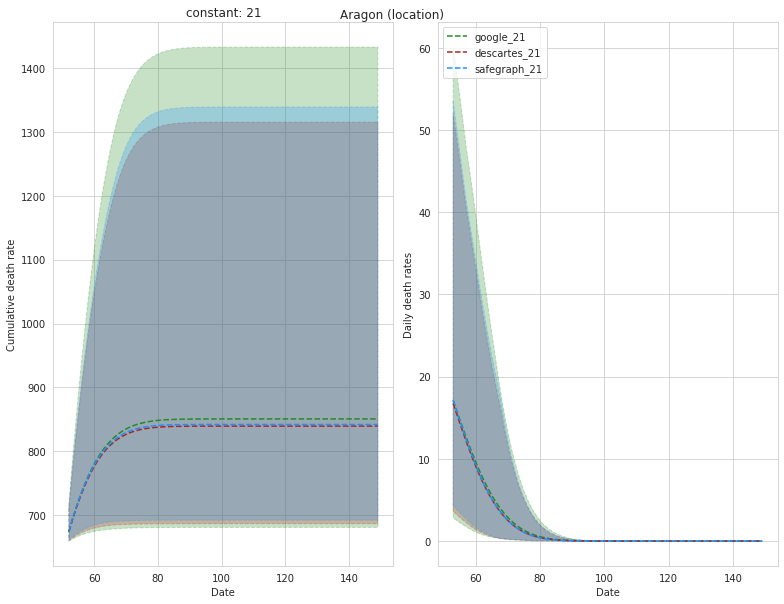

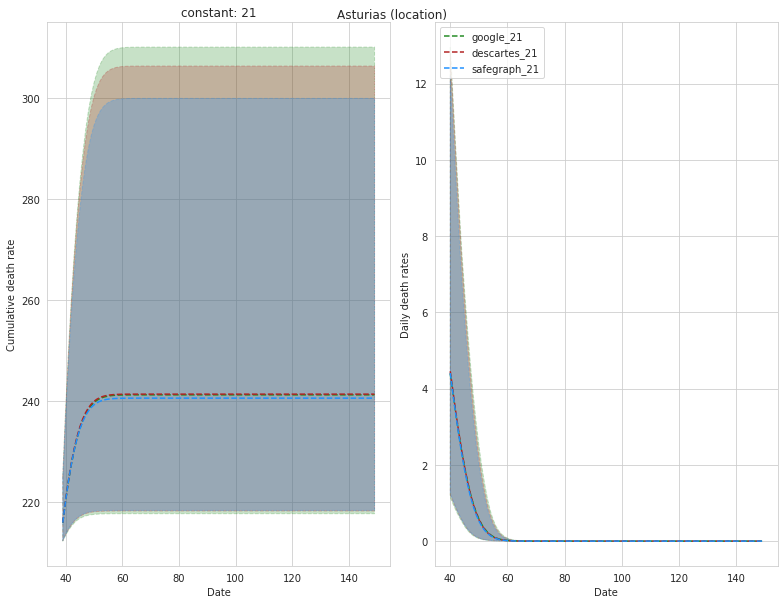

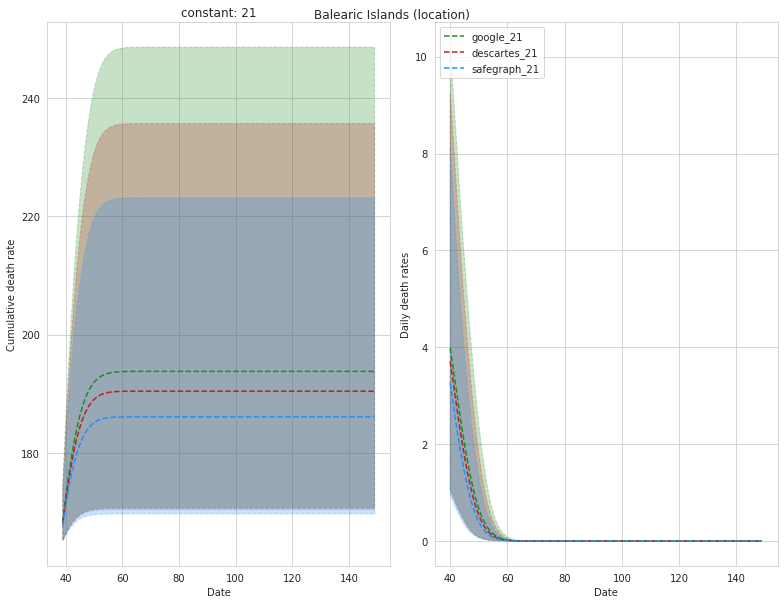

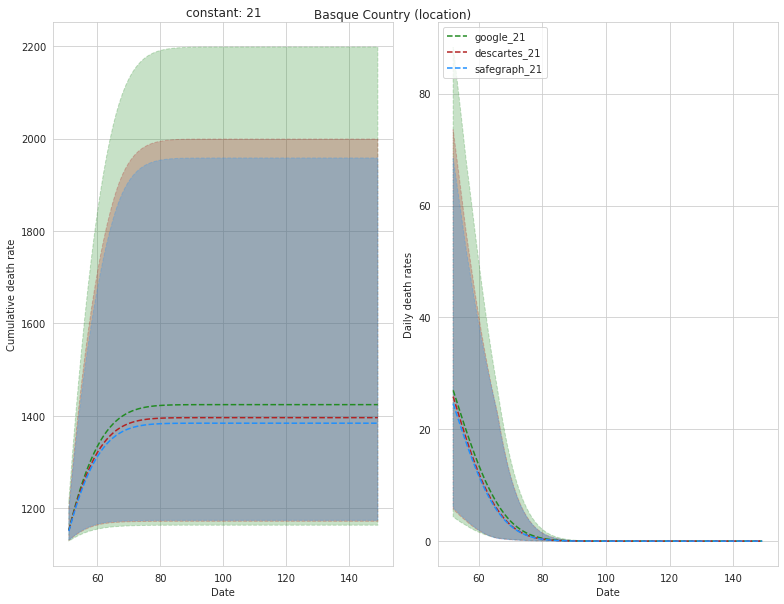

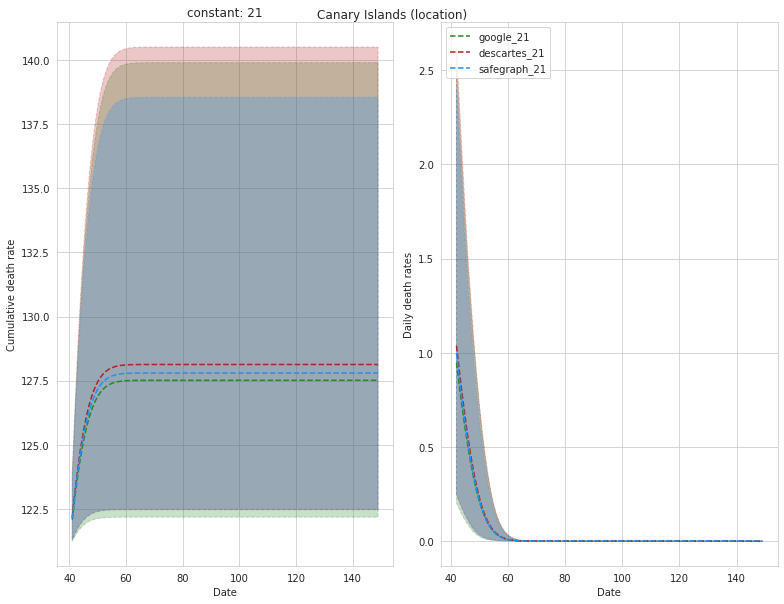

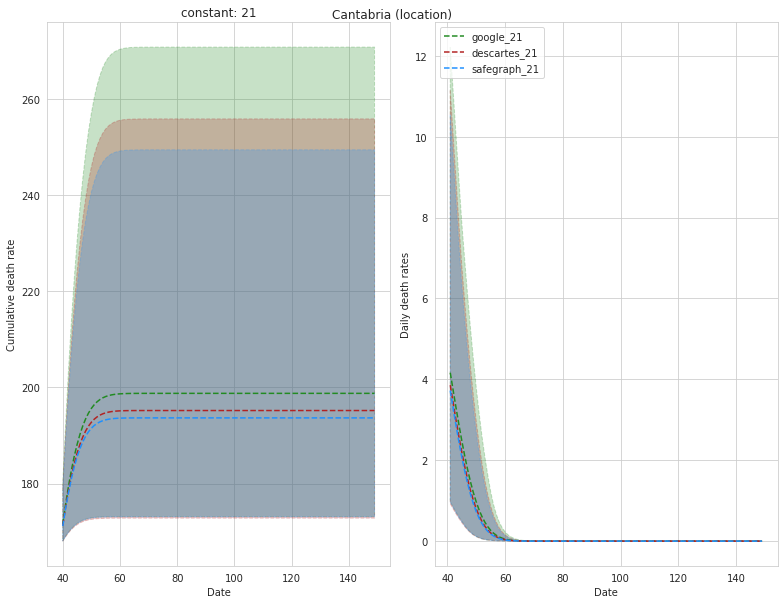

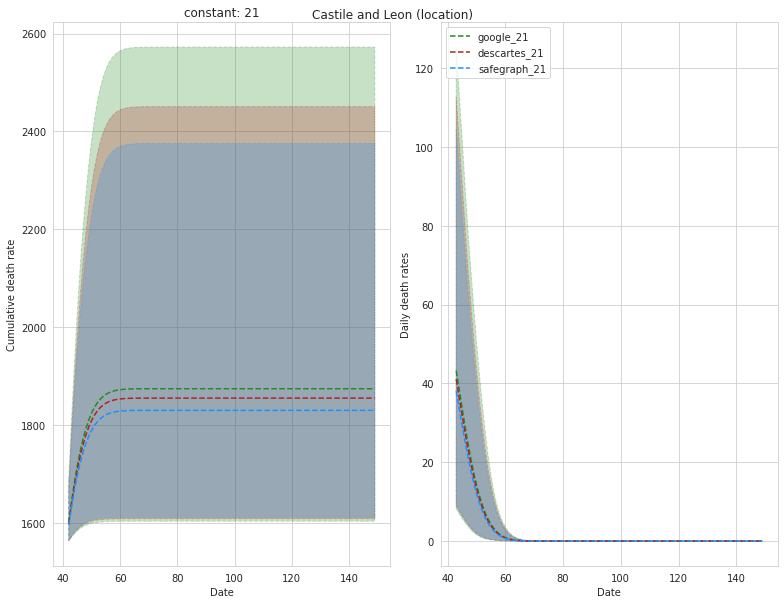

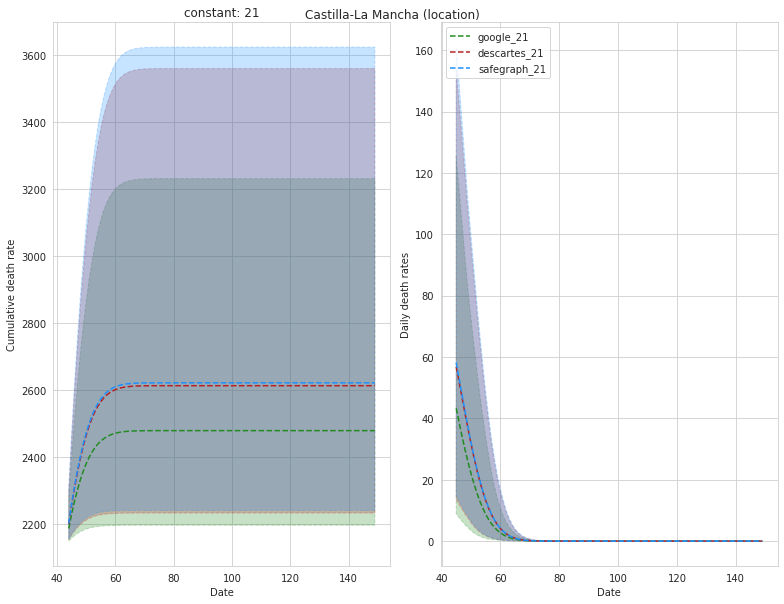

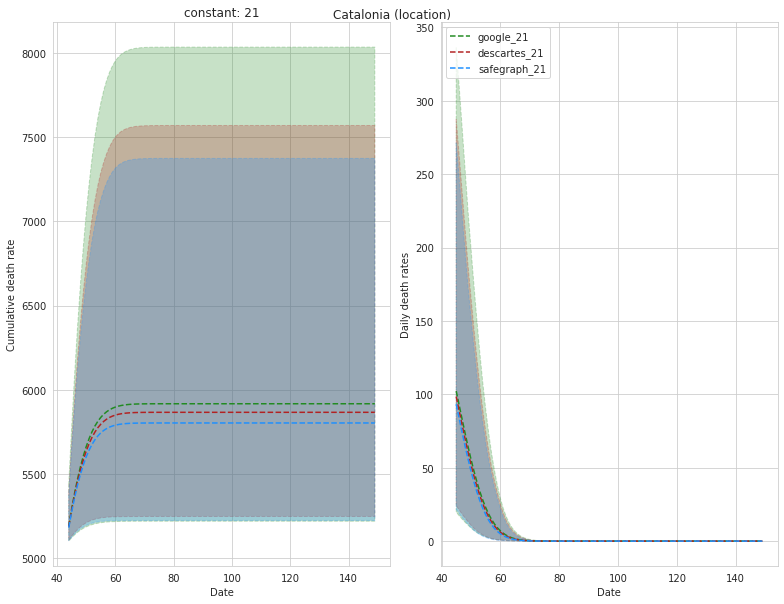

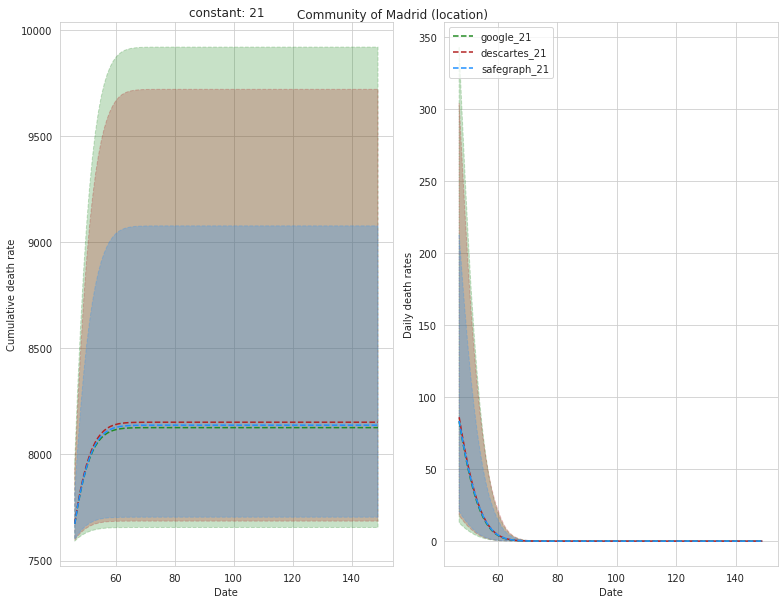

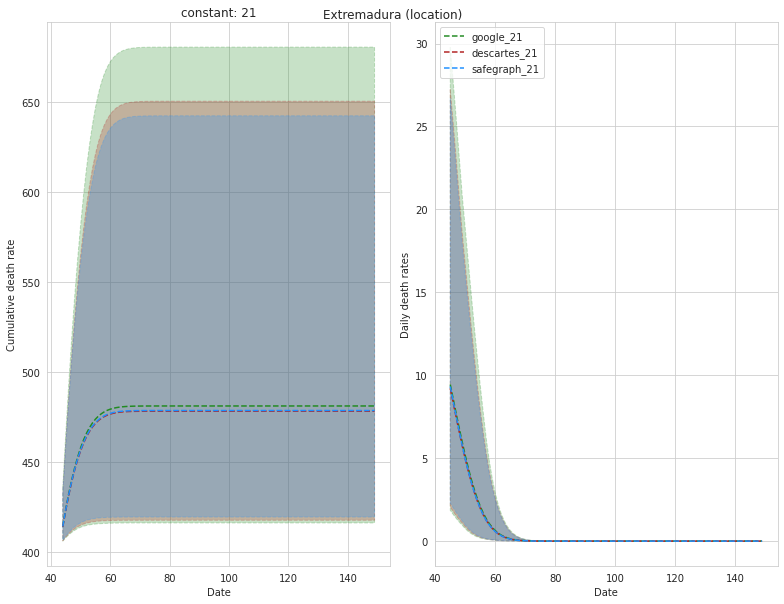

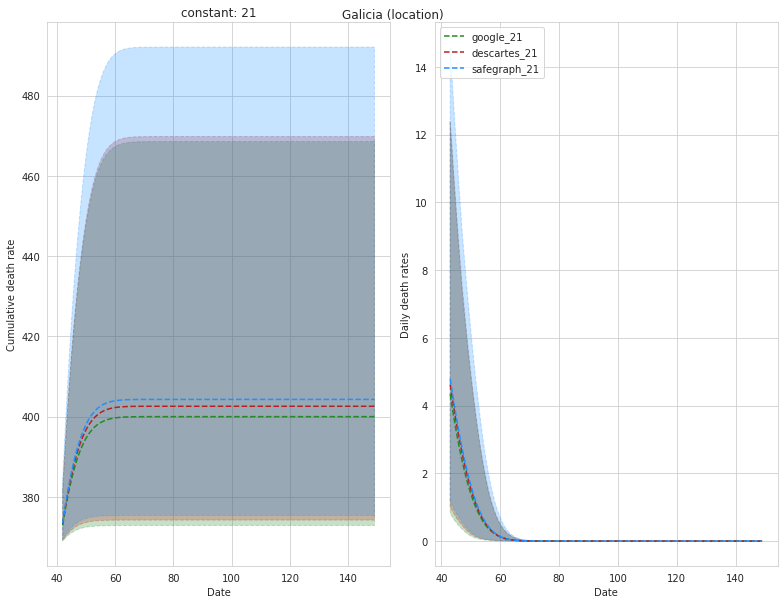

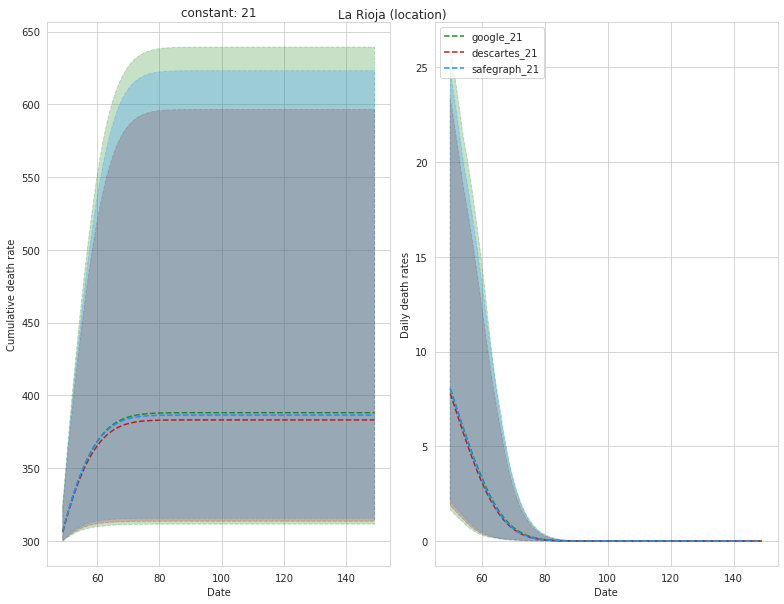

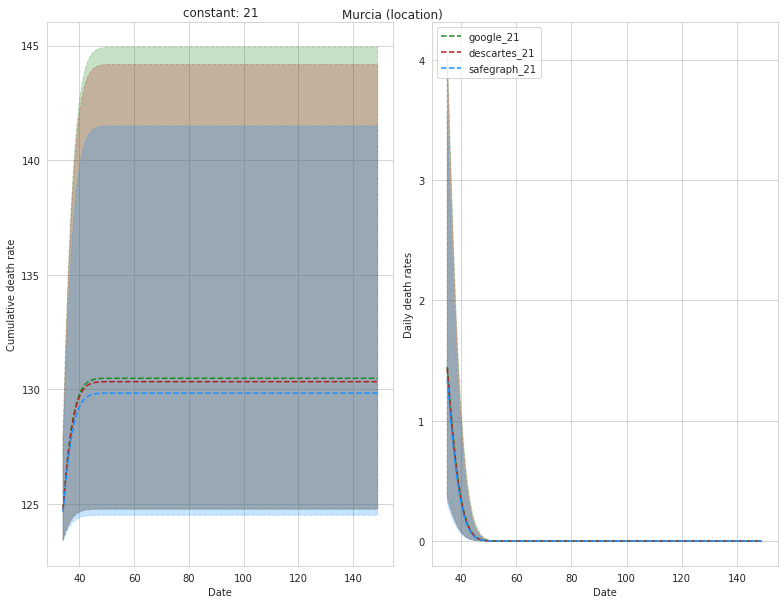

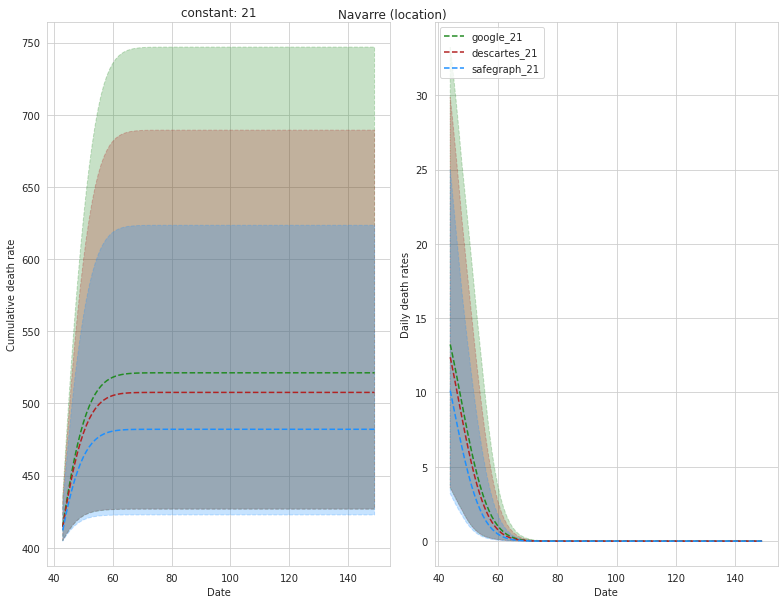

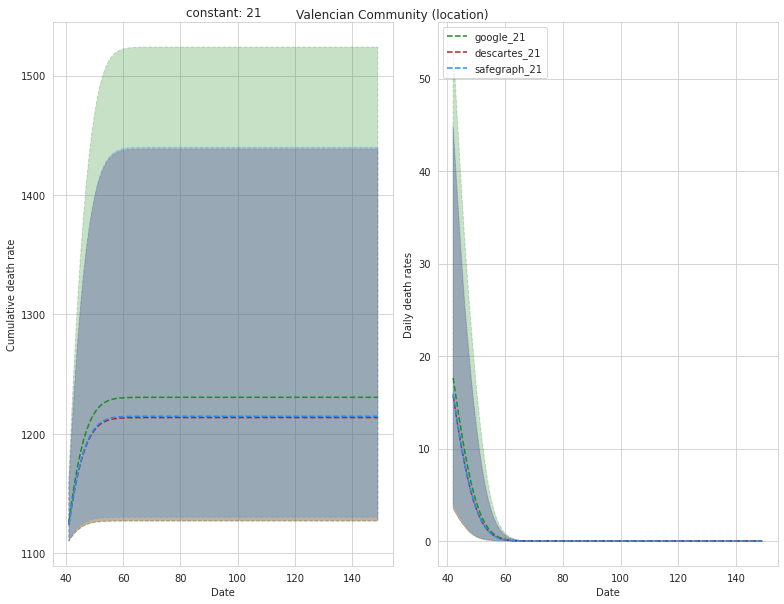

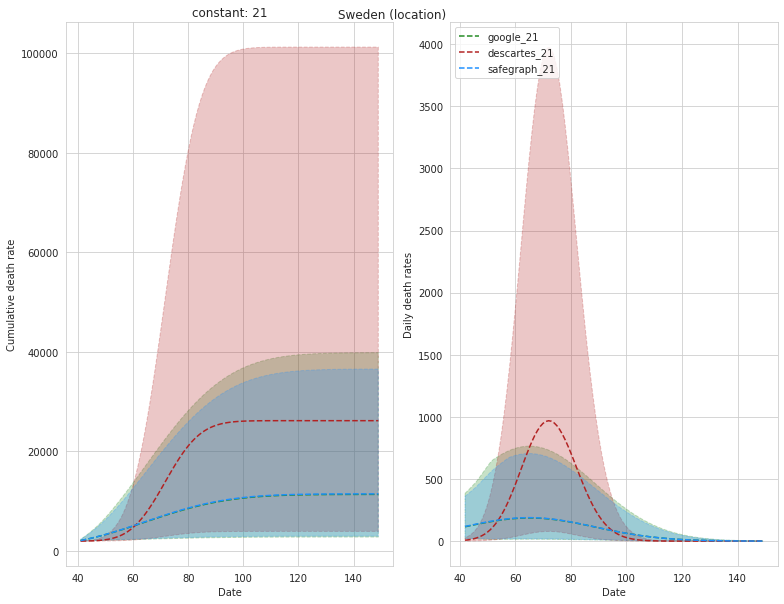

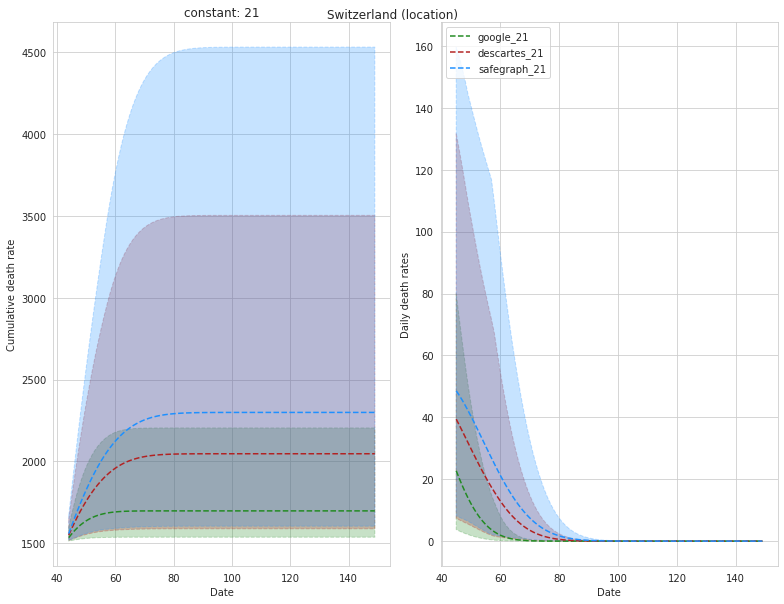

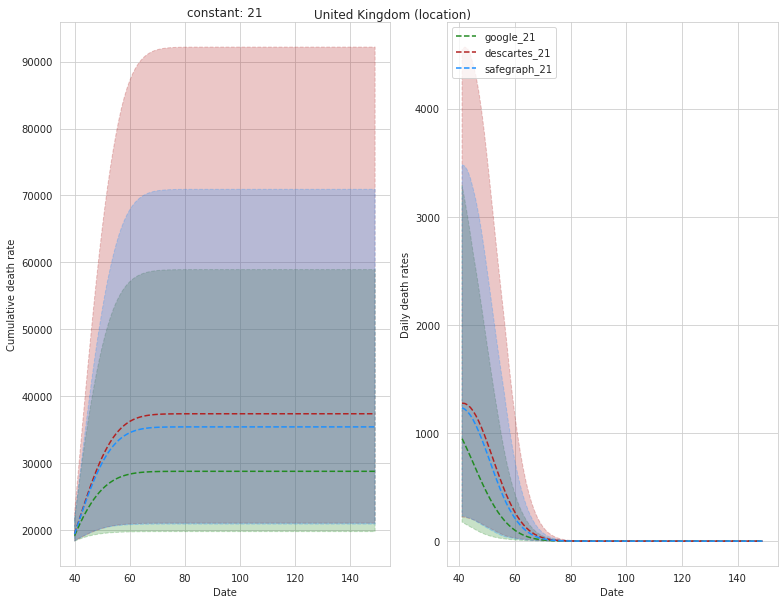

In [19]:
# combine everything
draw_dfs = []
past_draw_dfs = []
models_used = []
with PdfPages(f'{OUTPUT_DIR}/ensemble_plot.pdf') as pdf:
    for location_id, location_name in zip(euro_df['location_id'], euro_df['Location']):
        print(location_name)
        peak_duration = 1
        data_draws = Drawer(
            ensemble_dirs=submodel_dict[int(location_id)]['submodel_dirs'],
            n_draws_list=submodel_dict[int(location_id)]['n_draws_list'],
            location_name=location_name,
            location_id=int(location_id),
            peak_duration=1,
            obs_df=input_full_df[input_full_df['location_id'] == int(location_id)],
            date_draws=date_df.loc[date_df['location'] == location_name, [i for i in date_df.columns if i.startswith('death_date_draw_')]].values,
            population=input_age_pop_df.loc[input_age_pop_df['location_id'] == int(location_id), 'population'].sum(),
        )
        draw_df, past_draw_df, model_used, days, ensemble_draws = data_draws.get_dated_draws()
        draw_dfs.append(draw_df)
        past_draw_dfs.append(past_draw_df)
        models_used.append(model_used)

        # plot ensemble
        fig, ax = plt.subplots(1, 2, figsize=(11, 8.5))
        for label, draws in ensemble_draws.items():
            label = label.split('model_data_')[1]
            draws = np.exp(draws) * input_age_pop_df.loc[input_age_pop_df['location_id'] == int(location_id), 'population'].sum()
            deaths_mean = draws.mean(axis=0)
            deaths_lower = np.percentile(draws, 2.5, axis=0)
            deaths_upper = np.percentile(draws, 97.5, axis=0)

            d_deaths_mean = (draws[:,1:] - draws[:,:-1]).mean(axis=0)
            d_deaths_lower = np.percentile(draws[:,1:] - draws[:,:-1], 2.5, axis=0)
            d_deaths_upper = np.percentile(draws[:,1:] - draws[:,:-1], 97.5, axis=0)

            # cumulative
            ax[0].fill_between(days,
                               deaths_lower, deaths_upper,
                               color=COLOR_DICT[label.split('_')[0]],
                               linestyle=LINE_DICT[label.split('_')[1]],
                               alpha=0.25)
            ax[0].plot(days, deaths_mean,
                       c=COLOR_DICT[label.split('_')[0]],
                       linestyle=LINE_DICT[label.split('_')[1]], )
            ax[0].set_title(f'constant: {k}')
            ax[0].set_xlabel('Date')
            ax[0].set_ylabel('Cumulative death rate')

            # daily
            ax[1].fill_between(days[1:],
                               d_deaths_lower, d_deaths_upper,
                               color=COLOR_DICT[label.split('_')[0]],
                               linestyle=LINE_DICT[label.split('_')[1]],
                               alpha=0.25)
            ax[1].plot(days[1:], d_deaths_mean,
                       c=COLOR_DICT[label.split('_')[0]],
                       linestyle=LINE_DICT[label.split('_')[1]],
                       label=label.replace('model_data_', ''))
            ax[1].set_xlabel('Date')
            ax[1].set_ylabel('Daily death rates')

        ax[1].legend(loc=2)
        plt.suptitle(f'{location_name} ({model_used})')
        plt.tight_layout()
        pdf.savefig()
if 'location' not in models_used:
    raise ValueError('No location-specific draws used, must be using wrong tag')
draw_df = pd.concat(draw_dfs)
model_type_df = pd.DataFrame({
    'location':euro_df['Location'].to_list(),
    'model_used':models_used
})

# write
if 'draw_999' not in draw_df.columns:
    draw_df['draw_999'] = draw_df['draw_998']

draw_df.to_csv(f'{OUTPUT_DIR}/euro_data.csv', index=False)
model_type_df.to_csv(f'{OUTPUT_DIR}/euro_models_used.csv', index=False)
print(f'{OUTPUT_DIR}/euro_data.csv')


## combine with previous predictions

In [21]:
## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ##
# raw_draw_path = f'{OUTPUT_DIR}/euro_data.csv'
# average_draw_path = f'{OUTPUT_DIR}/past_avg_euro_data.csv'
# yesterday_draw_path = '/ihme/covid-19/deaths/prod/2020_04_17_Europe/euro_data.csv'
# before_yesterday_draw_path = '/ihme/covid-19/deaths/prod/2020_04_16_Europe/euro_data.csv'
## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ##

# Will this work?
if combine_predictions:
    avg_df = moving_average_predictions(
        today_data_path=raw_draw_path,
        yesterday_data_path=yesterday_draw_path,
        day_before_yesterday_path=before_yesterday_draw_path
    )
    avg_df['date'] = pd.to_datetime(avg_df['date'])
    past_draw_df = pd.concat(past_draw_dfs)

    ## NO NEED TO DO THIS, FOR NOW ##
    # avg_df = get_peak_date(past_draw_df, avg_df)

    # store data
    avg_df.to_csv(average_draw_path, index=False)
    print(average_draw_path)

    # plot
    plotter = CompareAveragingModelDeaths(
        raw_draw_path=raw_draw_path,
        average_draw_path=average_draw_path,
        yesterday_draw_path=yesterday_draw_path,
        before_yesterday_draw_path=before_yesterday_draw_path
        )
    plotter.make_some_pictures(f'{OUTPUT_DIR}/moving_average_compare.pdf',
                                'EEA + Australia + New Zealand')


Averaging over the following files:  ['/ihme/covid-19/deaths/prod/2020_04_22_Europe/euro_data.csv', '/ihme/covid-19/deaths/prod/2020_04_21_Europe/euro_data.csv', '/ihme/covid-19/deaths/prod/2020_04_20_Europe/euro_data.csv']


KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

In [ ]:
%debug

> /ihme/homes/aucarter/miniconda3/envs/covid-deaths-2020-04-22_21-48-41/lib/python3.6/site-packages/pandas/core/indexing.py(1655)_validate_read_indexer()
   1653             if not (ax.is_categorical() or ax.is_interval()):
   1654                 raise KeyError(
-> 1655                     "Passing list-likes to .loc or [] with any missing labels "
   1656                     "is no longer supported, see "
   1657                     "https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"  # noqa:E501



ipdb>  u


> /ihme/homes/aucarter/miniconda3/envs/covid-deaths-2020-04-22_21-48-41/lib/python3.6/site-packages/pandas/core/indexing.py(1553)_get_listlike_indexer()
   1551 
   1552         self._validate_read_indexer(
-> 1553             keyarr, indexer, o._get_axis_number(axis), raise_missing=raise_missing
   1554         )
   1555         return keyarr, indexer



ipdb>  u


> /ihme/homes/aucarter/miniconda3/envs/covid-deaths-2020-04-22_21-48-41/lib/python3.6/site-packages/pandas/core/indexing.py(1595)_getitem_iterable()
   1593         else:
   1594             # A collection of keys
-> 1595             keyarr, indexer = self._get_listlike_indexer(key, axis, raise_missing=False)
   1596             return self.obj._reindex_with_indexers(
   1597                 {axis: [keyarr, indexer]}, copy=True, allow_dups=True



ipdb>  u


> /ihme/homes/aucarter/miniconda3/envs/covid-deaths-2020-04-22_21-48-41/lib/python3.6/site-packages/pandas/core/indexing.py(1954)_getitem_axis()
   1952                     raise ValueError("Cannot index with multidimensional key")
   1953 
-> 1954                 return self._getitem_iterable(key, axis=axis)
   1955 
   1956             # nested tuple slicing



ipdb>  u


> /ihme/homes/aucarter/miniconda3/envs/covid-deaths-2020-04-22_21-48-41/lib/python3.6/site-packages/pandas/core/indexing.py(1768)__getitem__()
   1766 
   1767             maybe_callable = com.apply_if_callable(key, self.obj)
-> 1768             return self._getitem_axis(maybe_callable, axis=axis)
   1769 
   1770     def _is_scalar_access(self, key: Tuple):



ipdb>  u


> /ihme/homes/aucarter/covid19-modelling/covid-model-deaths/src/covid_model_deaths/moving_average.py(36)get_daily_predicted()
     34     data = data.set_index('location_id')
     35     # Broadcast latest data date over the location index.
---> 36     min_date = latest_data_date.loc[data.index]
     37     # Get the current data data for the dataset so that we can compute the
     38     # predicted daily deaths on the first predicted date.



ipdb>  u


> /ihme/homes/aucarter/covid19-modelling/covid-model-deaths/src/covid_model_deaths/moving_average.py(77)get_daily_predictions()
     75     latest_date = get_latest_data_date(today_data)
     76     today_predicted = get_daily_predicted(today_data, latest_date)
---> 77     yesterday_predicted = get_daily_predicted(yesterday_data, latest_date)
     78     day_before_yesterday_predicted = get_daily_predicted(day_before_yesterday_data, latest_date)
     79     all_predicted = pd.concat([today_predicted, yesterday_predicted, day_before_yesterday_predicted],



ipdb>  latest_date


location_id
47      2020-04-22
48      2020-04-22
51      2020-04-22
52      2020-04-22
55      2020-04-22
71      2020-04-22
75      2020-04-22
76      2020-04-22
78      2020-04-22
79      2020-04-22
80      2020-04-21
82      2020-04-22
84      2020-04-22
87      2020-04-22
89      2020-04-22
90      2020-04-22
91      2020-04-22
93      2020-04-22
94      2020-04-22
95      2020-04-22
97      2020-04-22
98      2020-04-22
111     2020-04-22
122     2020-04-22
123     2020-04-22
125     2020-04-22
132     2020-04-22
385     2020-04-22
4644    2020-04-22
4651    2020-04-22
4657    2020-04-22
4663    2020-04-22
4665    2020-04-22
4667    2020-04-22
4669    2020-04-22
4752    2020-04-22
4754    2020-04-22
4755    2020-04-22
4759    2020-04-22
4765    2020-04-22
4766    2020-04-22
4768    2020-04-22
4775    2020-04-22
35494   2020-04-22
35495   2020-04-22
35496   2020-04-22
35497   2020-04-22
35498   2020-04-22
35499   2020-04-22
35500   2020-04-22
35501   2020-04-22
35502   2020-04-22


In [ ]:
plotter = CompareModelDeaths(
    old_draw_path='/ihme/covid-19/deaths/prod/2020_04_16_Europe/euro_data.csv',
    new_draw_path=f'{OUTPUT_DIR}/euro_data.csv'
)
plotter.make_some_pictures(f'{OUTPUT_DIR}/compare_to_previous.pdf',
                           'EEA + others')


In [ ]:
viz_dir = f'/home/j/Project/covid/results/diagnostics/deaths/{DATESTAMP_LABEL}/'
if not os.path.exists(viz_dir):
    os.mkdir(viz_dir)
for viz_fp in ['compare_to_previous.pdf','ensemble_plot.pdf']: #'moving_average_compare.pdf']:
    shutil.copyfile(src=f"{OUTPUT_DIR}/{viz_fp}", dst=f"{viz_dir}/{viz_fp}")


In [ ]:
print(viz_dir)

In [ ]:
viz_dir = f'/home/j/Project/covid/results/diagnostics/deaths/{DATESTAMP_LABEL}/'
if not os.path.exists(viz_dir):
    os.mkdir(viz_dir)
for viz_fp in ['compare_to_previous.pdf','ensemble_plot.pdf']: #'moving_average_compare.pdf']:
    shutil.copyfile(src=f"{OUTPUT_DIR}/{viz_fp}", dst=f"{viz_dir}/{viz_fp}")


In [ ]:
print(viz_dir)